# Object detection on post images

In [60]:
import os
import urllib
import tarfile
import numpy as np

In [61]:
import matplotlib.pyplot as plt

%matplotlib inline

In [62]:
import tensorflow as tf

from distutils.version import StrictVersion

print('Using tensorflow version {0}'.format(tf.__version__))


Using tensorflow version 1.9.0


In [63]:
MODEL_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12'
MODEL_NAME = 'ssd_mobilenet_v2_oid_v4_2018_12_12'
MODEL_FILE = MODEL_NAME + '.tar.gz'

if os.path.exists(MODEL_FILE) is False:
    opener = urllib.request.URLopener()
    opener.retrieve(MODEL_DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

In [64]:
BOX_DESCRIPTIONS_FILE = 'class-descriptions-boxable.csv'
OID_DOWNLOAD_BASE = 'https://storage.googleapis.com/openimages/2018_04/'

if os.path.exists(BOX_DESCRIPTIONS_FILE) is False:
    opener = urllib.request.URLopener()
    opener.retrieve(OID_DOWNLOAD_BASE + BOX_DESCRIPTIONS_FILE, BOX_DESCRIPTIONS_FILE)

In [65]:
TEST_IMAGES = {
    'cat.jpg': 'https://c2.staticflickr.com/7/6118/6370710013_cb6b0270d3_o.jpg',
    'dog.jpg': 'https://c3.staticflickr.com/1/92/246323809_f8a8ab71fe_o.jpg',
    'pets.jpg': 'https://live.staticflickr.com/3273/2982384735_eeecaf03f2_b.jpg',
    'lion.jpg': '',
    'football.jpg': '',
}

for filename, url in TEST_IMAGES.items():
    if os.path.exists(filename) is False:
        opener = urllib.request.URLopener()
        opener.retrieve(url, filename)

In [66]:
FROZEN_GRAPH_FILE = 'frozen_inference_graph.pb'
PATH_TO_FROZEN_GRAPH = os.path.join(MODEL_NAME, FROZEN_GRAPH_FILE)

if os.path.exists(MODEL_NAME) is False:
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        filename = os.path.basename(file.name)
        if FROZEN_GRAPH_FILE in filename:
            tar_file.extract(file, os.getcwd())

In [67]:
import pandas as pd

ID_KEY = 'id'
CLASS_KEY = 'class'
NAME_KEY = 'name'

df = pd.read_csv(BOX_DESCRIPTIONS_FILE, names=[ID_KEY, CLASS_KEY])
df
category_index = {}
embeding_dict = {}
for idx, row in df.iterrows():
    category_index[idx+1] = {ID_KEY: row[ID_KEY], NAME_KEY: row[CLASS_KEY]}
    embeding_dict[row[CLASS_KEY]] = 0

In [68]:
category_index

{1: {'id': '/m/011k07', 'name': 'Tortoise'},
 2: {'id': '/m/011q46kg', 'name': 'Container'},
 3: {'id': '/m/012074', 'name': 'Magpie'},
 4: {'id': '/m/0120dh', 'name': 'Sea turtle'},
 5: {'id': '/m/01226z', 'name': 'Football'},
 6: {'id': '/m/012n7d', 'name': 'Ambulance'},
 7: {'id': '/m/012w5l', 'name': 'Ladder'},
 8: {'id': '/m/012xff', 'name': 'Toothbrush'},
 9: {'id': '/m/012ysf', 'name': 'Syringe'},
 10: {'id': '/m/0130jx', 'name': 'Sink'},
 11: {'id': '/m/0138tl', 'name': 'Toy'},
 12: {'id': '/m/013y1f', 'name': 'Organ'},
 13: {'id': '/m/01432t', 'name': 'Cassette deck'},
 14: {'id': '/m/014j1m', 'name': 'Apple'},
 15: {'id': '/m/014sv8', 'name': 'Human eye'},
 16: {'id': '/m/014trl', 'name': 'Cosmetics'},
 17: {'id': '/m/014y4n', 'name': 'Paddle'},
 18: {'id': '/m/0152hh', 'name': 'Snowman'},
 19: {'id': '/m/01599', 'name': 'Beer'},
 20: {'id': '/m/01_5g', 'name': 'Chopsticks'},
 21: {'id': '/m/015h_t', 'name': 'Human beard'},
 22: {'id': '/m/015p6', 'name': 'Bird'},
 23: {'id':

In [69]:
embeding_dict

{'Tortoise': 0,
 'Container': 0,
 'Magpie': 0,
 'Sea turtle': 0,
 'Football': 0,
 'Ambulance': 0,
 'Ladder': 0,
 'Toothbrush': 0,
 'Syringe': 0,
 'Sink': 0,
 'Toy': 0,
 'Organ': 0,
 'Cassette deck': 0,
 'Apple': 0,
 'Human eye': 0,
 'Cosmetics': 0,
 'Paddle': 0,
 'Snowman': 0,
 'Beer': 0,
 'Chopsticks': 0,
 'Human beard': 0,
 'Bird': 0,
 'Parking meter': 0,
 'Traffic light': 0,
 'Croissant': 0,
 'Cucumber': 0,
 'Radish': 0,
 'Towel': 0,
 'Doll': 0,
 'Skull': 0,
 'Washing machine': 0,
 'Glove': 0,
 'Tick': 0,
 'Belt': 0,
 'Sunglasses': 0,
 'Banjo': 0,
 'Cart': 0,
 'Ball': 0,
 'Backpack': 0,
 'Bicycle': 0,
 'Home appliance': 0,
 'Centipede': 0,
 'Boat': 0,
 'Surfboard': 0,
 'Boot': 0,
 'Headphones': 0,
 'Hot dog': 0,
 'Shorts': 0,
 'Fast food': 0,
 'Bus': 0,
 'Boy': 0,
 'Screwdriver': 0,
 'Bicycle wheel': 0,
 'Barge': 0,
 'Laptop': 0,
 'Miniskirt': 0,
 'Drill': 0,
 'Dress': 0,
 'Bear': 0,
 'Waffle': 0,
 'Pancake': 0,
 'Brown bear': 0,
 'Woodpecker': 0,
 'Blue jay': 0,
 'Pretzel': 0,
 'Ba

In [70]:
graph = tf.Graph()
with graph.as_default():
    graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(graph_def, name='')

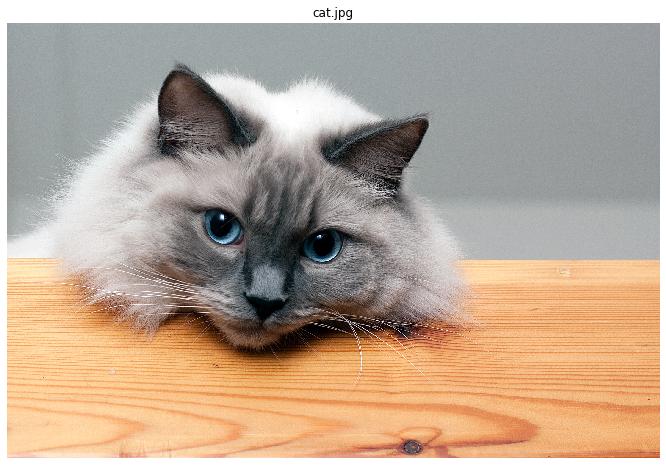

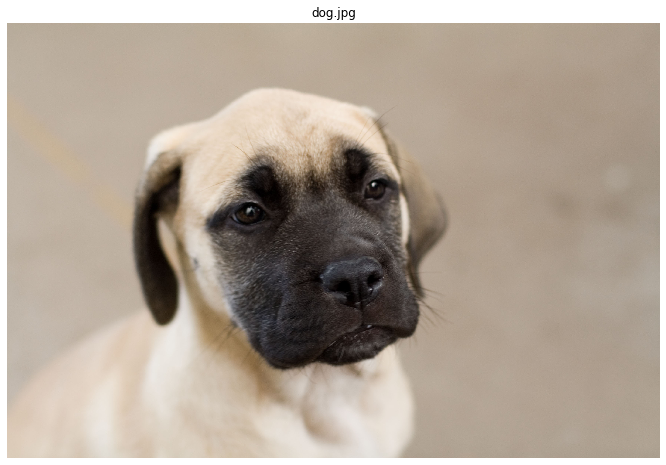

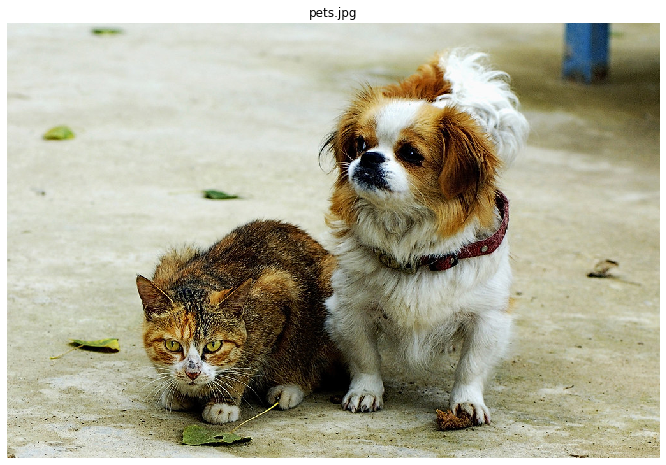

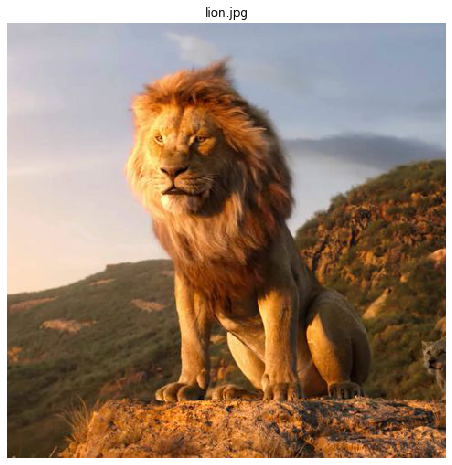

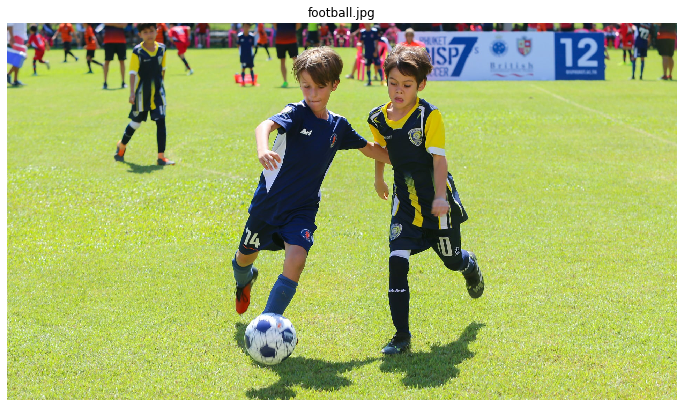

In [71]:
from PIL import Image

IMAGE_SIZE = (12, 8)


def show_image(filename, image):
    
    plt.figure(figsize=IMAGE_SIZE)
    plt.title(filename)
    plt.axis('off')
    plt.imshow(image)


for filename, _ in TEST_IMAGES.items():
    original_image = Image.open(filename)
    show_image(filename, original_image)

In [72]:
# Font to draw text on image
FONT_NAME = 'Ubuntu-R.ttf'

# Bounding box colors
COLORS = ['Green',
          'Red', 'Pink',
          'Olive', 'Brown', 'Gray',
          'Cyan', 'Orange']

In [73]:
class ObjectResult:

    def __init__(self, label, score, box):
        self.label = label
        self.score = score
        self.box = box
    
    def __repr__(self):
        return '{0} ({1}%)'.format(self.label, int(100 * self.score))

In [74]:
N_CHANNELS = 3

def load_image_into_numpy_array(image):
    
    (width, height) = image.size
    return np.array(image.getdata()).reshape((height, width, N_CHANNELS)).astype(np.uint8)

In [75]:
def process_output(classes, scores, boxes, category_index):

    results = []

    for clazz, score, box in zip(classes, scores, boxes):
        if score > 0.0:
            label = category_index[clazz][NAME_KEY]
            obj_result = ObjectResult(label, score, box)
            results.append(obj_result)
    
    return results

In [76]:
import random
import PIL.Image as Image

def draw_labeled_boxes(image_np, results, min_score=.4):

    results.sort(key=lambda x: x.score, reverse=False)
    image_np_copy = image_np.copy()
    for r in results:
        if r.score >= min_score:
            color_idx = random.randint(0, len(COLORS) - 1)
            color = COLORS[color_idx]

            image_pil = Image.fromarray(np.uint8(image_np_copy)).convert('RGB')
            draw_bounding_box_on_image(image_pil, r.box, color, str(r))
            np.copyto(image_np_copy, np.array(image_pil))

    return image_np_copy

In [77]:
import PIL.ImageFont as ImageFont

def get_suitable_font_for_text(text, img_width, font_name, img_fraction=0.12):
    fontsize = 1
    font = ImageFont.truetype(FONT_NAME, fontsize)
    while font.getsize(text)[0] < img_fraction*img_width:
        fontsize += 1
        font = ImageFont.truetype(font_name, fontsize)
    return font

In [78]:
import PIL.ImageDraw as ImageDraw

TEXT_COLOR = 'Black'

def draw_bounding_box_on_image(image, box, color, box_label):
    im_width, im_height = image.size
    top, left, bottom, right = box

    # Normalize coordinates
    left = left * im_width
    right = right * im_width
    top = top * im_height
    bottom = bottom * im_height

    # Draw the detected bounding box
    line_width = int(max(im_width, im_height) * 0.005)
    draw = ImageDraw.Draw(image)
    draw.rectangle(((left, top), (right, bottom)),
                   width=line_width,
                   outline=color)

    # Get a suitable font (in terms of size with respect to the image)
    font = get_suitable_font_for_text(box_label, im_width, FONT_NAME)
    text_width, text_height = font.getsize(box_label)

    # Draw the box label rectangle
    text_bottom = top + text_height
    text_rect = ((left, top),
                 (left + text_width + 2 * line_width,
                  text_bottom + 2 * line_width))
    draw.rectangle(text_rect, fill=color)

    # Draw the box label text 
    # right below the upper-left horizontal line of the bounding box
    text_position = (left + line_width, top + line_width)
    draw.text(text_position, box_label, fill=TEXT_COLOR, font=font)

In [79]:
# Input tensor
IMAGE_TENSOR_KEY = 'image_tensor'

# Output tensors
DETECTION_BOXES_KEY = 'detection_boxes'
DETECTION_SCORES_KEY = 'detection_scores'
DETECTION_CLASSES_KEY = 'detection_classes'

TENSOR_SUFFIX = ':0'

def run_inference(graph, image_np):
    
    output_tensor_dict = {
        DETECTION_BOXES_KEY: DETECTION_BOXES_KEY + TENSOR_SUFFIX,
        DETECTION_SCORES_KEY: DETECTION_SCORES_KEY + TENSOR_SUFFIX,
        DETECTION_CLASSES_KEY: DETECTION_CLASSES_KEY + TENSOR_SUFFIX
    }

    with graph.as_default():
        with tf.Session() as sess:
            input_tensor = tf.get_default_graph().get_tensor_by_name(IMAGE_TENSOR_KEY + TENSOR_SUFFIX)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            input_tensor_dict = {input_tensor: image_np_expanded}
            output_dict = sess.run(output_tensor_dict, feed_dict=input_tensor_dict)

            return {
                DETECTION_BOXES_KEY: 
                    output_dict[DETECTION_BOXES_KEY][0],
                DETECTION_SCORES_KEY: 
                    output_dict[DETECTION_SCORES_KEY][0],
                DETECTION_CLASSES_KEY: 
                    output_dict[DETECTION_CLASSES_KEY][0].astype(np.int64)
            }

In [80]:
IMAGE_NP_KEY = 'image_np'
RESULTS_KEY = 'results'

file_result_dict = {}

for filename, _ in TEST_IMAGES.items():
    
    if filename in file_result_dict.keys():
        continue
    
    print(filename)
    
    image_np = load_image_into_numpy_array(Image.open(filename))
    
    output_dict = run_inference(graph, image_np)
 
    results = process_output(output_dict[DETECTION_CLASSES_KEY],
                             output_dict[DETECTION_SCORES_KEY],
                             output_dict[DETECTION_BOXES_KEY],
                             category_index)

    file_result_dict[filename] = { IMAGE_NP_KEY: image_np, RESULTS_KEY: results }

cat.jpg
dog.jpg
pets.jpg
lion.jpg
football.jpg


[Cat (90%)]
[Dog (94%)]
[Dog (83%), Cat (90%)]
[Lion (34%), Dog (59%)]
[Boy (39%), Person (50%), Boy (61%), Football (80%)]


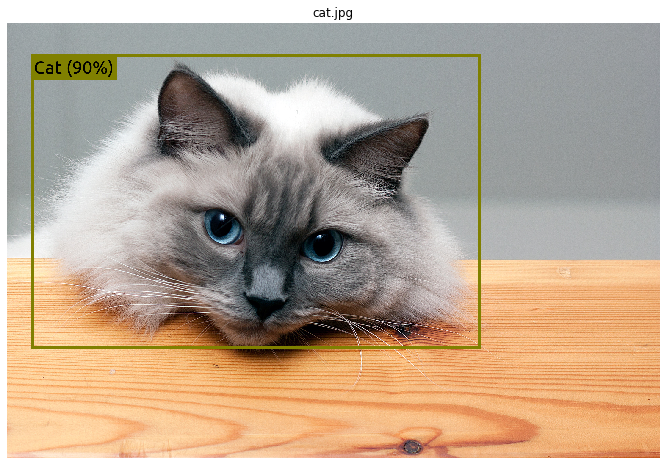

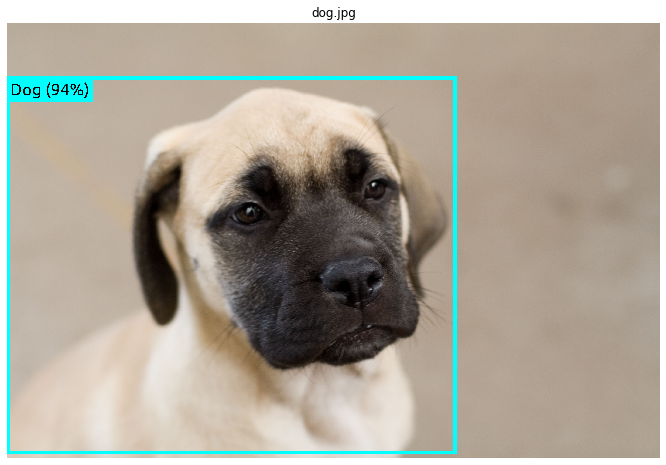

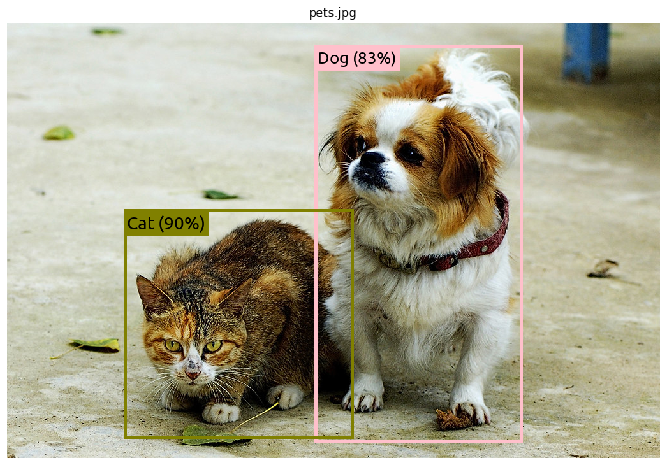

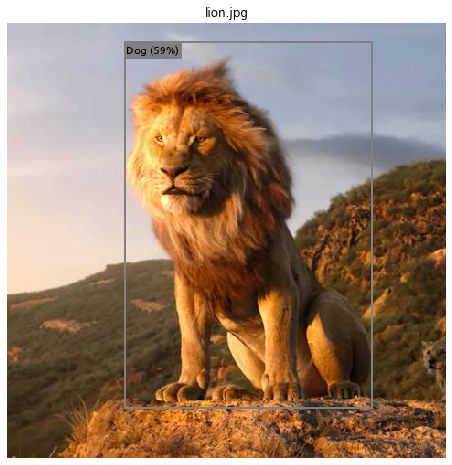

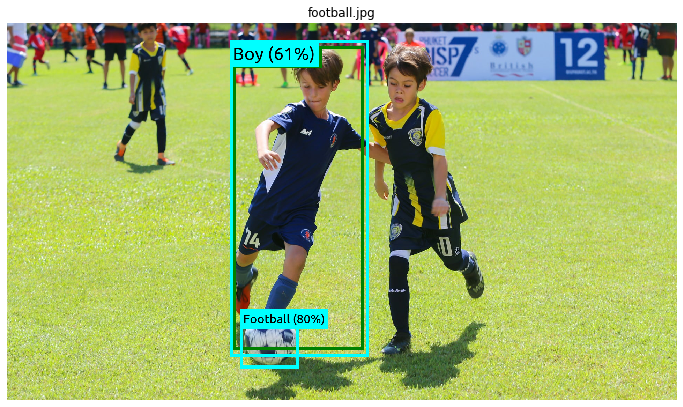

In [81]:
for filename, img_results_dict in file_result_dict.items():
    processed_image = draw_labeled_boxes(img_results_dict[IMAGE_NP_KEY], img_results_dict[RESULTS_KEY])
    show_image(filename, processed_image)
    print(img_results_dict[RESULTS_KEY])

In [82]:
filename = 'football.jpg'

image_np = load_image_into_numpy_array(Image.open(filename))

output_dict = run_inference(graph, image_np)

results = process_output(output_dict[DETECTION_CLASSES_KEY],
                         output_dict[DETECTION_SCORES_KEY],
                         output_dict[DETECTION_BOXES_KEY],
                         category_index)

file_result_dict[filename] = { IMAGE_NP_KEY: image_np, RESULTS_KEY: results }

[Boy (39%), Person (50%), Boy (61%), Football (80%)]


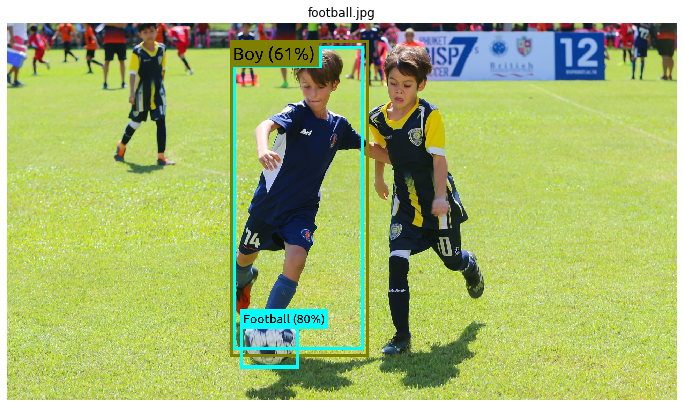

In [83]:
processed_image = draw_labeled_boxes(file_result_dict[filename][IMAGE_NP_KEY], file_result_dict[filename][RESULTS_KEY])
show_image(filename, processed_image)
print(img_results_dict[RESULTS_KEY])

In [84]:
import copy

help_dict = copy.deepcopy(embeding_dict)

objects_set = set()

for item in img_results_dict[RESULTS_KEY]:
    if item.score > 0.4:
        objects_set.add(item.label)
        help_dict[item.label] += 1

help_dict
help_dict.values()

for set_item in objects_set:
    print(set_item, ":", help_dict[set_item])

Football : 1
Person : 1
Boy : 1


In [199]:
from os import listdir

adjusting = False
last_detected = ''
folder_path = '../scraped_database_tags_new'

for ind, img in enumerate(os.listdir(folder_path)):
    
    if ind%100==0:
        print("Checkpoint on", ind)
    
    if adjusting:
        if img == last_detected:
            adjusting = False
        continue
    
    detect_objects(folder_path + "/" + img)

# detect_objects('test_detection/a2RBOxp.jpg')

Checkpoint on 0
Detection on image ../scraped_database_tags_new/a0Nv0Pd.jpg
Detection on image ../scraped_database_tags_new/a0Nv1bq.jpg
Man : 1
Human face : 6
Detection on image ../scraped_database_tags_new/a0Nv1jn.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/a0Nv3ed.jpg
Detection on image ../scraped_database_tags_new/a0Nv4Yv.jpg
Man : 2
Woman : 1
Clothing : 2
Detection on image ../scraped_database_tags_new/a0Nv7Vn.jpg
Detection on image ../scraped_database_tags_new/a0Nv85Q.jpg
Tree : 1
Detection on image ../scraped_database_tags_new/a0Nv9nL.jpg
Detection on image ../scraped_database_tags_new/a0NvB0n.jpg
Train : 1
Detection on image ../scraped_database_tags_new/a0NvB3X.jpg
Detection on image ../scraped_database_tags_new/a0NvB4v.jpg
Man : 1
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/a0NvB5d.jpg
Cat : 1
Detection on image ../scraped_database_tags_new/a0NvB8L.jpg
Human face : 1
Person : 1
Detection on image ../scraped_database_tags_ne

Man : 2
Woman : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/a0NvyZZ.jpg
Detection on image ../scraped_database_tags_new/a0NvzbB.jpg
Car : 1
Detection on image ../scraped_database_tags_new/a0NvzjO.jpg
Toy : 1
Detection on image ../scraped_database_tags_new/a0Nvznn.jpg
Detection on image ../scraped_database_tags_new/a0NvZOn.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a0NvzQd.jpg
Detection on image ../scraped_database_tags_new/a0NvzwL.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a0NvzXv.jpg
Detection on image ../scraped_database_tags_new/a0RmAKX.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/a0RmmjZ.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a1R4z4D.jpg
Human face : 1
Boy : 1
Detection on image ../scraped_database_tags_new/a1R4zjw.jpg
Man : 1
Detection on image ../scraped_database_tags_new/a1Wp0BG.jpg
Poster : 1
Detection on image ../scraped_database_tags_new/a1Wp1Yv.jpg
Detection o

Human face : 2
Person : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/a1Wpx8b.jpg
Detection on image ../scraped_database_tags_new/a1WpxLP.jpg
Detection on image ../scraped_database_tags_new/a1WpxN6.jpg
Man : 1
Human face : 1
Clothing : 2
Detection on image ../scraped_database_tags_new/a1Wpxo8.jpg
Car : 2
Detection on image ../scraped_database_tags_new/a1WpxpP.jpg
Detection on image ../scraped_database_tags_new/a1Wpy3D.jpg
Detection on image ../scraped_database_tags_new/a1Wpy52.jpg
Detection on image ../scraped_database_tags_new/a1Wpy7v.jpg
Snack : 1
Detection on image ../scraped_database_tags_new/a1Wpy8G.jpg
Detection on image ../scraped_database_tags_new/a1Wpy98.jpg
Detection on image ../scraped_database_tags_new/a1WpybG.jpg
Detection on image ../scraped_database_tags_new/a1WpyeP.jpg
Detection on image ../scraped_database_tags_new/a1Wpymv.jpg
Detection on image ../scraped_database_tags_new/a1WpyMw.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a1Wp

Detection on image ../scraped_database_tags_new/a2WEV9d.jpg
Human face : 1
Clothing : 1
Woman : 1
Detection on image ../scraped_database_tags_new/a2WEVE1.jpg
Tree : 1
Detection on image ../scraped_database_tags_new/a2WEVrw.jpg
Car : 1
Detection on image ../scraped_database_tags_new/a2WEVYe.jpg
Man : 1
Human face : 2
Woman : 1
Detection on image ../scraped_database_tags_new/a2WEx4w.jpg
Man : 1
Human face : 2
Clothing : 1
Detection on image ../scraped_database_tags_new/a2WEx5d.jpg
Human face : 2
Person : 1
Detection on image ../scraped_database_tags_new/a2WEx8p.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/a2WEXRp.jpg
Detection on image ../scraped_database_tags_new/a2WExvD.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/a2WExxe.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a2WEXY9.jpg
Human face : 1
Boy : 1
Detection on image ../scraped_database_tags_new/a2WEY8O.jpg
Detection on image ../scraped_database_tags_new/a2WEYbd.jpg
D

Detection on image ../scraped_database_tags_new/a3wvwDN.jpg
Person : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/a3wvWX5.jpg
Man : 2
Human face : 3
Detection on image ../scraped_database_tags_new/a3wvX48.jpg
Detection on image ../scraped_database_tags_new/a3wvX77.jpg
Man : 5
Human face : 2
Detection on image ../scraped_database_tags_new/a3wvX83.jpg
Man : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/a3wvXAr.jpg
Detection on image ../scraped_database_tags_new/a3wvXD5.jpg
Person : 1
Detection on image ../scraped_database_tags_new/a3wvXdN.jpg
Detection on image ../scraped_database_tags_new/a3wvxem.jpg
Detection on image ../scraped_database_tags_new/a3wvXj7.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a3wvXKe.jpg
Detection on image ../scraped_database_tags_new/a3wvXLm.jpg
Detection on image ../scraped_database_tags_new/a3wvxLN.jpg
Toy : 2
Detection on image ../scraped_database_tags_new/a3wvXM5.jpg
Human face : 2
Detection on image .

Human face : 1
Detection on image ../scraped_database_tags_new/a43pwg6.jpg
Detection on image ../scraped_database_tags_new/a43pwLv.jpg
Baked goods : 1
Detection on image ../scraped_database_tags_new/a43pwNy.jpg
Person : 1
Detection on image ../scraped_database_tags_new/a43px4p.jpg
Toy : 1
Person : 1
Detection on image ../scraped_database_tags_new/a43pX8Q.jpg
Man : 1
Human face : 2
Clothing : 1
Woman : 1
Detection on image ../scraped_database_tags_new/a43pX9m.jpg
Detection on image ../scraped_database_tags_new/a43pXAZ.jpg
Detection on image ../scraped_database_tags_new/a43pXBQ.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a43pXDd.jpg
Man : 1
Human face : 1
Clothing : 3
Detection on image ../scraped_database_tags_new/a43pxDw.jpg
Man : 1
Detection on image ../scraped_database_tags_new/a43pXe1.jpg
Poster : 1
Human face : 2
Woman : 1
Detection on image ../scraped_database_tags_new/a43pXmp.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a43pxMv.jpg
Det

Detection on image ../scraped_database_tags_new/a5WpOBo.jpg
Man : 1
Woman : 1
Clothing : 2
Detection on image ../scraped_database_tags_new/a5WpODE.jpg
Detection on image ../scraped_database_tags_new/a5WpOEy.jpg
Detection on image ../scraped_database_tags_new/a5WpOmL.jpg
Detection on image ../scraped_database_tags_new/a5WpOMr.jpg
Man : 1
Poster : 1
Human face : 1
Detection on image ../scraped_database_tags_new/a5WpOpg.jpg
Human face : 2
Clothing : 1
Woman : 1
Checkpoint on 700
Detection on image ../scraped_database_tags_new/a5WpOQL.jpg
Man : 4
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/a5WpoVr.jpg
Person : 2
Detection on image ../scraped_database_tags_new/a5WpOWV.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a5WpOyq.jpg
Person : 1
Detection on image ../scraped_database_tags_new/a5WpPBq.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a5WppEg.jpg
Human face : 3
Person : 1
Detection on image ../scraped_database_tags_n

Motorcycle : 1
Person : 1
Detection on image ../scraped_database_tags_new/a6KrRKR.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/a6KrRO2.jpg
Detection on image ../scraped_database_tags_new/a6KrRoN.jpg
Cat : 1
Detection on image ../scraped_database_tags_new/a6KrVDe.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a6KrVRA.jpg
Man : 2
Human face : 1
Detection on image ../scraped_database_tags_new/a6Krw4L.jpg
Detection on image ../scraped_database_tags_new/a6KrwQL.jpg
Bicycle : 1
Detection on image ../scraped_database_tags_new/a6KrX1L.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a6Krx4A.jpg
Detection on image ../scraped_database_tags_new/a6KrxAm.jpg
Detection on image ../scraped_database_tags_new/a6Krxbb.jpg
Detection on image ../scraped_database_tags_new/a6Krxdq.jpg
Detection on image ../scraped_database_tags_new/a6Krxjq.jpg
Stairs : 1
Detection on image ../scraped_database_tags_new/a6Krxqm.jpg
Tree : 1
Detection on image

Frying pan : 1
Detection on image ../scraped_database_tags_new/a7WvRDr.jpg
Person : 1
Detection on image ../scraped_database_tags_new/a7WvRdz.jpg
Detection on image ../scraped_database_tags_new/a7WvRGA.jpg
Detection on image ../scraped_database_tags_new/a7WvRjw.jpg
Person : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/a7WvRKq.jpg
Person : 1
Detection on image ../scraped_database_tags_new/a7WvRMe.jpg
Parrot : 1
Detection on image ../scraped_database_tags_new/a7Wvrnq.jpg
Detection on image ../scraped_database_tags_new/a7WvRO2.jpg
Detection on image ../scraped_database_tags_new/a7WvRRm.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a7WvRwm.jpg
Man : 2
Human face : 3
Detection on image ../scraped_database_tags_new/a7WvRzL.jpg
Detection on image ../scraped_database_tags_new/a7WvVOr.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a7WvvRL.jpg
Detection on image ../scraped_database_tags_new/a7WvwXe.jpg
Detection on image ../scraped_datab

Detection on image ../scraped_database_tags_new/a8GdQK6.jpg
Person : 1
Detection on image ../scraped_database_tags_new/a8GdQKp.jpg
Person : 1
Detection on image ../scraped_database_tags_new/a8GdQr1.jpg
Poster : 1
Clothing : 1
Human face : 1
Detection on image ../scraped_database_tags_new/a8GdQrY.jpg
Detection on image ../scraped_database_tags_new/a8GdQvd.jpg
Fireplace : 1
Detection on image ../scraped_database_tags_new/a8GdQy3.jpg
Man : 1
Human face : 2
Detection on image ../scraped_database_tags_new/a8GdQY6.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a8GdQzQ.jpg
Human face : 2
Alpaca : 1
Man : 1
Woman : 1
Clothing : 2
Detection on image ../scraped_database_tags_new/a8GdR0Q.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a8GdR31.jpg
Man : 1
Detection on image ../scraped_database_tags_new/a8GdR4O.jpg
Detection on image ../scraped_database_tags_new/a8GdR5V.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a8GdR8Y.jpg
Man : 3
Huma

Man : 1
Human face : 3
Detection on image ../scraped_database_tags_new/a9nj82m.jpg
Person : 1
Detection on image ../scraped_database_tags_new/a9nj8DL.jpg
Detection on image ../scraped_database_tags_new/a9nj8VL.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a9nj8YD.jpg
Human face : 1
Boy : 1
Detection on image ../scraped_database_tags_new/a9nj8yZ.jpg
Swimming pool : 1
Detection on image ../scraped_database_tags_new/a9njAZo.jpg
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/a9njB5o.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/a9njB6D.jpg
Mug : 1
Detection on image ../scraped_database_tags_new/a9njB8W.jpg
Detection on image ../scraped_database_tags_new/a9njbEK.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/a9njBem.jpg
Detection on image ../scraped_database_tags_new/a9njbgj.jpg
Detection on image ../scraped_database_tags_new/a9njBK0.jpg
Man : 2
Detection on image ../scraped_database_tags_new/a9njBPj.jpg
Det

Person : 1
Detection on image ../scraped_database_tags_new/a9njw5m.jpg
Person : 2
Detection on image ../scraped_database_tags_new/a9njw6K.jpg
Detection on image ../scraped_database_tags_new/a9njw9j.jpg
Man : 1
Woman : 1
Clothing : 2
Detection on image ../scraped_database_tags_new/a9njwbL.jpg
Detection on image ../scraped_database_tags_new/a9njwK6.jpg
Toy : 1
Detection on image ../scraped_database_tags_new/a9njwXL.jpg
Detection on image ../scraped_database_tags_new/a9njx06.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/a9njx2L.jpg
Computer monitor : 2
Computer keyboard : 1
Detection on image ../scraped_database_tags_new/a9njx3K.jpg
Detection on image ../scraped_database_tags_new/a9njx7o.jpg
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/a9njxA6.jpg
Detection on image ../scraped_database_tags_new/a9njxBD.jpg
Woman : 2
Clothing : 2
Human face : 2
Detection on image ../scraped_database_tags_new/a9njxEj.jpg
Fish : 1
Detection on image

Woman : 1
Footwear : 1
Detection on image ../scraped_database_tags_new/aAeBGpd.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aAeBGVo.jpg
Detection on image ../scraped_database_tags_new/aAeBgZ0.jpg
Wheel : 1
Detection on image ../scraped_database_tags_new/aAeBj00.jpg
Detection on image ../scraped_database_tags_new/aAeBj2E.jpg
Billboard : 1
Detection on image ../scraped_database_tags_new/aAeBj59.jpg
Building : 1
Detection on image ../scraped_database_tags_new/aAeBj6Z.jpg
Laptop : 1
Detection on image ../scraped_database_tags_new/aAeBj7g.jpg
Man : 2
Human face : 2
Detection on image ../scraped_database_tags_new/aAeBjA2.jpg
Food : 1
Detection on image ../scraped_database_tags_new/aAeBjBE.jpg
Detection on image ../scraped_database_tags_new/aAeBjbp.jpg
Detection on image ../scraped_database_tags_new/aAeBjD2.jpg
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aAeBjdg.jpg
Detection on image ../scraped_database_tags_new/aAeBjep.jpg
Man : 

Human face : 1
Detection on image ../scraped_database_tags_new/abG37PL.jpg
Person : 2
Clothing : 1
Detection on image ../scraped_database_tags_new/abG37VO.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/abG37X8.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/abG37xB.jpg
Checkpoint on 1500
Detection on image ../scraped_database_tags_new/abG37Yp.jpg
Man : 1
Human face : 1
Woman : 1
Detection on image ../scraped_database_tags_new/abG37z9.jpg
Detection on image ../scraped_database_tags_new/abG38Mb.jpg
Man : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/abG38OO.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/abG38Rr.jpg
Detection on image ../scraped_database_tags_new/abG38v9.jpg
Detection on image ../scraped_database_tags_new/abG3AGr.jpg
Detection on image ../scraped_database_tags_new/abG3bg8.jpg
Car : 1
Detection on image ../scraped_database_tags_new/abG3d0L.jpg
Clothing : 1
Detection on image ../scraped_data

Human face : 1
Detection on image ../scraped_database_tags_new/aBm9A8Z.jpg
Footwear : 2
Detection on image ../scraped_database_tags_new/aBm9A9Q.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aBm9AAD.jpg
Man : 2
Person : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aBm9ABN.jpg
Detection on image ../scraped_database_tags_new/aBm9Adx.jpg
Poster : 1
Detection on image ../scraped_database_tags_new/aBm9AEQ.jpg
Person : 1
Detection on image ../scraped_database_tags_new/aBm9AeZ.jpg
Human face : 1
Person : 1
Billboard : 1
Detection on image ../scraped_database_tags_new/aBm9AGQ.jpg
Detection on image ../scraped_database_tags_new/aBm9ALP.jpg
Man : 4
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aBm9ALz.jpg
Detection on image ../scraped_database_tags_new/aBm9AmD.jpg
Detection on image ../scraped_database_tags_new/aBm9AmN.jpg
Detection on image ../scraped_database_tags_new/aBm9ANA.jpg
Stop sign : 1
Detection on image ../scr

Human face : 1
Person : 1
Detection on image ../scraped_database_tags_new/aBm9p7Z.jpg
Poster : 1
Detection on image ../scraped_database_tags_new/aBm9P9P.jpg
Mirror : 1
Detection on image ../scraped_database_tags_new/aBm9p9x.jpg
Car : 1
Detection on image ../scraped_database_tags_new/aBm9pDN.jpg
Woman : 1
Dress : 1
Detection on image ../scraped_database_tags_new/aBm9pDZ.jpg
Detection on image ../scraped_database_tags_new/aBm9peA.jpg
Owl : 1
Detection on image ../scraped_database_tags_new/aBm9pEx.jpg
Man : 2
Human face : 2
Detection on image ../scraped_database_tags_new/aBm9pGP.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aBm9pj2.jpg
Human face : 1
Person : 1
Detection on image ../scraped_database_tags_new/aBm9pjQ.jpg
Human face : 1
Clothing : 1
Woman : 1
Detection on image ../scraped_database_tags_new/aBm9pKz.jpg
Bicycle : 1
Detection on image ../scraped_database_tags_new/aBm9pLD.jpg
Detection on image ../scraped_database_tags_new/aBm9pMO.jpg
Man : 2
Woman 

Detection on image ../scraped_database_tags_new/aD4RGzx.jpg
Human face : 1
Brassiere : 1
Detection on image ../scraped_database_tags_new/aD4RK1d.jpg
Man : 1
Poster : 1
Detection on image ../scraped_database_tags_new/aD4RK4K.jpg
Detection on image ../scraped_database_tags_new/aD4RK4O.jpg
Footwear : 1
Detection on image ../scraped_database_tags_new/aD4RK5d.jpg
Poster : 1
Human face : 1
Boy : 1
Detection on image ../scraped_database_tags_new/aD4RK77.jpg
Detection on image ../scraped_database_tags_new/aD4RK7G.jpg
Man : 2
Clothing : 2
Detection on image ../scraped_database_tags_new/aD4RK8N.jpg
Man : 1
Detection on image ../scraped_database_tags_new/aD4RK9d.jpg
Detection on image ../scraped_database_tags_new/aD4RKAx.jpg
Detection on image ../scraped_database_tags_new/aD4RKDK.jpg
Detection on image ../scraped_database_tags_new/aD4RKEK.jpg
Clothing : 1
Detection on image ../scraped_database_tags_new/aD4RKG9.jpg
Detection on image ../scraped_database_tags_new/aD4RKgO.jpg
Man : 1
Person : 1
Dete

Person : 1
Detection on image ../scraped_database_tags_new/aD4RyRG.jpg
Poster : 1
Animal : 1
Detection on image ../scraped_database_tags_new/aD4RyWx.jpg
Bicycle : 1
Detection on image ../scraped_database_tags_new/aD4RyWZ.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aD4RyX7.jpg
Detection on image ../scraped_database_tags_new/aD4Ryx9.jpg
Man : 2
Detection on image ../scraped_database_tags_new/aD4Ryyw.jpg
Detection on image ../scraped_database_tags_new/aD4RyZG.jpg
Detection on image ../scraped_database_tags_new/aD4RyzZ.jpg
Detection on image ../scraped_database_tags_new/aD4RzLw.jpg
Man : 3
Human face : 3
Detection on image ../scraped_database_tags_new/aD4RZR7.jpg
Detection on image ../scraped_database_tags_new/ad53ZxV.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aDgBBbK.jpg
Man : 1
Poster : 2
Detection on image ../scraped_database_tags_new/adVy11Z.jpg
Man : 1
Woman : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/adVy1jV.jpg
Foot

Detection on image ../scraped_database_tags_new/adVyWz2.jpg
Poster : 2
Person : 1
Human face : 1
Detection on image ../scraped_database_tags_new/adVywzB.jpg
Human face : 1
Person : 1
Detection on image ../scraped_database_tags_new/adVyxeM.jpg
Detection on image ../scraped_database_tags_new/adVyYKV.jpg
Clothing : 1
Detection on image ../scraped_database_tags_new/adVyYxZ.jpg
Man : 2
Human face : 3
Detection on image ../scraped_database_tags_new/adVyzA2.jpg
Hamster : 1
Dog : 1
Detection on image ../scraped_database_tags_new/adVyzjN.jpg
Detection on image ../scraped_database_tags_new/adVyzNQ.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/adVyzoQ.jpg
Detection on image ../scraped_database_tags_new/adVyzPB.jpg
Poster : 1
Detection on image ../scraped_database_tags_new/adVyzvd.jpg
Detection on image ../scraped_database_tags_new/ae5XovO.jpg
Man : 2
Human face : 3
Detection on image ../scraped_database_tags_new/ae5Xvom.jpg
Detection on image ../scraped_database_tags_

Man : 1
Suit : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aeDKLwW.jpg
Detection on image ../scraped_database_tags_new/aeDKn0W.jpg
Man : 3
Human face : 3
Detection on image ../scraped_database_tags_new/aeDKn1m.jpg
Detection on image ../scraped_database_tags_new/aeDKn2p.jpg
Detection on image ../scraped_database_tags_new/aeDKn6v.jpg
Detection on image ../scraped_database_tags_new/aeDKnAj.jpg
Man : 1
Detection on image ../scraped_database_tags_new/aeDKnDq.jpg
Flag : 1
Detection on image ../scraped_database_tags_new/aeDKnEb.jpg
Fish : 1
Detection on image ../scraped_database_tags_new/aeDKngj.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aeDKnLj.jpg
Detection on image ../scraped_database_tags_new/aeDKnMO.jpg
Man : 2
Human face : 2
Detection on image ../scraped_database_tags_new/aeDKnmp.jpg
Detection on image ../scraped_database_tags_new/aeDKnpW.jpg
Detection on image ../scraped_database_tags_new/aeDKnQ5.jpg
Cat : 1
Computer keyboard : 1
Det

Cat : 2
Detection on image ../scraped_database_tags_new/aEPd5K9.jpg
Checkpoint on 2300
Detection on image ../scraped_database_tags_new/aEPd5Pn.jpg
Human face : 3
Clothing : 2
Woman : 1
Detection on image ../scraped_database_tags_new/aEPd5qN.jpg
Man : 1
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aEPd6AN.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aEPd6NK.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aEPd6We.jpg
Human face : 1
Clothing : 1
Car : 1
Detection on image ../scraped_database_tags_new/aEPd70x.jpg
Person : 1
Detection on image ../scraped_database_tags_new/aEPd93x.jpg
Detection on image ../scraped_database_tags_new/aEPd96K.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/aEPd98x.jpg
Man : 1
Person : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aEPd9BN.jpg
Person : 1
Detection on image ../scraped_database_tags_new/aEPd9eo.jpg
Detection on image ../scraped_database_tags_

Airplane : 1
Detection on image ../scraped_database_tags_new/agAr666.jpg
Person : 1
Detection on image ../scraped_database_tags_new/agAr6Ax.jpg
Detection on image ../scraped_database_tags_new/agAr6p6.jpg
Door : 1
Detection on image ../scraped_database_tags_new/agAr6Pw.jpg
Detection on image ../scraped_database_tags_new/agAr6Qv.jpg
Person : 1
Detection on image ../scraped_database_tags_new/agAr786.jpg
Detection on image ../scraped_database_tags_new/agAr7O1.jpg
Human face : 1
Dog : 1
Detection on image ../scraped_database_tags_new/agAr8Bv.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/agAr9bw.jpg
Computer keyboard : 1
Detection on image ../scraped_database_tags_new/agAr9jr.jpg
Man : 3
Human face : 3
Detection on image ../scraped_database_tags_new/agAr9Yw.jpg
Convenience store : 1
Detection on image ../scraped_database_tags_new/agArAvn.jpg
Detection on image ../scraped_database_tags_new/agArAXv.jpg
Detection on image ../scraped_database_tags_new/agArAzg.jpg
Vehicle reg

Man : 1
Human face : 2
Jacket : 1
Detection on image ../scraped_database_tags_new/aGdK255.jpg
Person : 2
Clothing : 1
Detection on image ../scraped_database_tags_new/aGdK2V6.jpg
Woman : 1
Human face : 2
Detection on image ../scraped_database_tags_new/aGdK40G.jpg
Human face : 1
Person : 2
Detection on image ../scraped_database_tags_new/aGdK426.jpg
Goat : 1
Detection on image ../scraped_database_tags_new/aGdK43X.jpg
Footwear : 3
Detection on image ../scraped_database_tags_new/aGdK44w.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aGdK44z.jpg
Detection on image ../scraped_database_tags_new/aGdK45w.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aGdK480.jpg
Detection on image ../scraped_database_tags_new/aGdK4A6.jpg
Person : 1
Detection on image ../scraped_database_tags_new/aGdK4bK.jpg
Car : 1
Detection on image ../scraped_database_tags_new/aGdK4e5.jpg
Detection on image ../scraped_database_tags_new/aGdK4EX.jpg
Human face : 1
Person : 2
Detection on i

Car : 1
Detection on image ../scraped_database_tags_new/aGdKpKz.jpg
Detection on image ../scraped_database_tags_new/aGdKpqn.jpg
Detection on image ../scraped_database_tags_new/aGdKpWK.jpg
Detection on image ../scraped_database_tags_new/aGdKqbK.jpg
Detection on image ../scraped_database_tags_new/aGdKQDz.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/aGdKQe7.jpg
Clothing : 1
Detection on image ../scraped_database_tags_new/aGdKQjX.jpg
Detection on image ../scraped_database_tags_new/aGdKqK6.jpg
Detection on image ../scraped_database_tags_new/aGdKQL6.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aGdKQO5.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aGdKqPX.jpg
Building : 1
Detection on image ../scraped_database_tags_new/aGdKqv5.jpg
Detection on image ../scraped_database_tags_new/aGdKr0z.jpg
Man : 1
Detection on image ../scraped_database_tags_new/aGdKr30.jpg
Footwear : 1
Detection on image ../scraped_database_tags_new/aGdKrE0.jpg

Human face : 1
Detection on image ../scraped_database_tags_new/aj9QOQx.jpg
Detection on image ../scraped_database_tags_new/aj9Qp0q.jpg
Woman : 1
Detection on image ../scraped_database_tags_new/aj9Qp3G.jpg
Man : 1
Toy : 1
Detection on image ../scraped_database_tags_new/aj9QP40.jpg
Man : 1
Human face : 1
Woman : 1
Dress : 1
Detection on image ../scraped_database_tags_new/aj9Qp48.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aj9Qp6q.jpg
Person : 1
Clothing : 3
Detection on image ../scraped_database_tags_new/aj9Qp88.jpg
Rabbit : 1
Detection on image ../scraped_database_tags_new/aj9Qp9x.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/aj9QpDG.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aj9QpEQ.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/aj9QpGG.jpg
Person : 1
Cattle : 1
Detection on image ../scraped_database_tags_new/aj9QpOg.jpg
Detection on image ../scraped_database_tags_new/aj9QpQp.jpg
Detection on image

Person : 1
Detection on image ../scraped_database_tags_new/aK74pVg.jpg
Man : 1
Detection on image ../scraped_database_tags_new/aK74pyg.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aK74Q6Z.jpg
Detection on image ../scraped_database_tags_new/aK74Q96.jpg
Horse : 1
Detection on image ../scraped_database_tags_new/aK74QA6.jpg
Man : 2
Woman : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aK74QB1.jpg
Window : 1
Detection on image ../scraped_database_tags_new/aK74QGg.jpg
Poster : 1
Detection on image ../scraped_database_tags_new/aK74Qjj.jpg
Man : 1
Detection on image ../scraped_database_tags_new/aK74QL1.jpg
Detection on image ../scraped_database_tags_new/aK74QoW.jpg
Fruit : 1
Detection on image ../scraped_database_tags_new/aK74Qp1.jpg
Sculpture : 1
Detection on image ../scraped_database_tags_new/aK74QqN.jpg
Paddle : 1
Detection on image ../scraped_database_tags_new/aK74QRZ.jpg
Detection on image ../scraped_database_tags_new/aK74QXb.jpg
Detection on

Detection on image ../scraped_database_tags_new/aLw6oZ6.jpg
Detection on image ../scraped_database_tags_new/aLw6OZv.jpg
Detection on image ../scraped_database_tags_new/aLw6pR5.jpg
Man : 2
Human face : 3
Clothing : 3
Woman : 1
Detection on image ../scraped_database_tags_new/aLw6QKA.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aLw6r1W.jpg
Man : 1
Human face : 7
Clothing : 2
Woman : 3
Detection on image ../scraped_database_tags_new/aLw6rgP.jpg
Detection on image ../scraped_database_tags_new/aLw6rMA.jpg
Person : 1
Detection on image ../scraped_database_tags_new/aLw6rOA.jpg
Clothing : 1
Detection on image ../scraped_database_tags_new/aLw6rQ6.jpg
Detection on image ../scraped_database_tags_new/aLw6ryW.jpg
Detection on image ../scraped_database_tags_new/aLw6V2P.jpg
Detection on image ../scraped_database_tags_new/aLw6VAg.jpg
Elephant : 1
Cattle : 1
Detection on image ../scraped_database_tags_new/aLw6VmA.jpg
Detection on image ../scraped_database_tags_new/aLw6VwM.jpg
Human

Horse : 1
Detection on image ../scraped_database_tags_new/amvqBbv.jpg
Footwear : 3
Detection on image ../scraped_database_tags_new/amvqbdo.jpg
Man : 1
Human face : 2
Detection on image ../scraped_database_tags_new/amvqbKj.jpg
Detection on image ../scraped_database_tags_new/amvqbL9.jpg
Man : 1
Person : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/amvqbno.jpg
Car : 1
Detection on image ../scraped_database_tags_new/amvqbx4.jpg
Detection on image ../scraped_database_tags_new/amvqbyj.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/amvqbZ2.jpg
Detection on image ../scraped_database_tags_new/amvqbzd.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/amvqd2y.jpg
Man : 1
Human face : 4
Detection on image ../scraped_database_tags_new/amvqdn2.jpg
Detection on image ../scraped_database_tags_new/amvqdo4.jpg
Detection on image ../scraped_database_tags_new/amvqdVj.jpg
Human face : 1
Boy : 1
Detection on image ../scraped_database_tags_new/amvqdwX.jp

Detection on image ../scraped_database_tags_new/amvqZ3o.jpg
Detection on image ../scraped_database_tags_new/amvqZB9.jpg
Woman : 1
Detection on image ../scraped_database_tags_new/amvqzD2.jpg
Man : 1
Detection on image ../scraped_database_tags_new/amvqZPo.jpg
Detection on image ../scraped_database_tags_new/amvqZq6.jpg
Detection on image ../scraped_database_tags_new/amvqZv9.jpg
Boy : 1
Detection on image ../scraped_database_tags_new/amvqZvo.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aMxe02R.jpg
Detection on image ../scraped_database_tags_new/aMxe086.jpg
Footwear : 1
Detection on image ../scraped_database_tags_new/aMxe09P.jpg
Man : 2
Clothing : 2
Detection on image ../scraped_database_tags_new/aMxe0PV.jpg
Man : 4
Clothing : 1
Detection on image ../scraped_database_tags_new/aMxe0VM.jpg
Detection on image ../scraped_database_tags_new/aMxe0xx.jpg
Detection on image ../scraped_database_tags_new/aMxe1MW.jpg
Human face : 2
Clothing : 1
Woman : 1
Detection on image ../scra

Woman : 2
Detection on image ../scraped_database_tags_new/an4e0jV.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/an4e0oV.jpg
Man : 2
Human face : 1
Woman : 2
Detection on image ../scraped_database_tags_new/an4e0q5.jpg
Detection on image ../scraped_database_tags_new/an4e0Xo.jpg
Man : 1
Detection on image ../scraped_database_tags_new/an4e1jb.jpg
Detection on image ../scraped_database_tags_new/an4e2V0.jpg
Man : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/an4e39B.jpg
Person : 1
Detection on image ../scraped_database_tags_new/an4e3e0.jpg
Detection on image ../scraped_database_tags_new/an4e3gV.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/an4e3gz.jpg
Man : 2
Poster : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/an4e3OL.jpg
Detection on image ../scraped_database_tags_new/an4e3zV.jpg
Detection on image ../scraped_database_tags_new/an4e4Rz.jpg
Detection on image ../scraped_database_tags_new/an4e5E0.jpg

Human face : 2
Detection on image ../scraped_database_tags_new/an4ePwB.jpg
Detection on image ../scraped_database_tags_new/an4ePxn.jpg
Man : 1
Woman : 1
Clothing : 2
Dress : 1
Detection on image ../scraped_database_tags_new/an4ePyo.jpg
Detection on image ../scraped_database_tags_new/an4ePzL.jpg
Detection on image ../scraped_database_tags_new/an4eQ7E.jpg
Detection on image ../scraped_database_tags_new/an4eRg0.jpg
Man : 2
Human face : 2
Detection on image ../scraped_database_tags_new/an4erm5.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/an4eRmn.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/an4erZ0.jpg
Toy : 1
Person : 1
Detection on image ../scraped_database_tags_new/an4erzo.jpg
Mobile phone : 2
Detection on image ../scraped_database_tags_new/an4ev45.jpg
Man : 2
Human face : 2
Detection on image ../scraped_database_tags_new/an4eV5V.jpg
Detection on image ../scraped_database_tags_new/an4eVBo.jpg
Human face : 4
Boy : 1
Detection on image ../scraped

Detection on image ../scraped_database_tags_new/aNgmj64.jpg
Detection on image ../scraped_database_tags_new/aNgmjXG.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aNgmKj4.jpg
Detection on image ../scraped_database_tags_new/aNgmLmA.jpg
Man : 1
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aNgmM7w.jpg
Man : 2
Human face : 2
Detection on image ../scraped_database_tags_new/aNgmmBb.jpg
Clothing : 1
Detection on image ../scraped_database_tags_new/aNgmmLr.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/aNgmmpG.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aNgmMy6.jpg
Detection on image ../scraped_database_tags_new/aNgmMzb.jpg
Insect : 2
Beetle : 1
Detection on image ../scraped_database_tags_new/aNgmn1b.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aNgmN2G.jpg
Man : 1
Detection on image ../scraped_database_tags_new/aNgmN3v.jpg
Detection on image ../scraped_database_tags_new/aN

Man : 1
Shirt : 1
Detection on image ../scraped_database_tags_new/aO7oM56.jpg
Detection on image ../scraped_database_tags_new/aO7oM6E.jpg
Detection on image ../scraped_database_tags_new/aO7oMbv.jpg
Building : 1
Detection on image ../scraped_database_tags_new/aO7oMdN.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aO7oMgE.jpg
Detection on image ../scraped_database_tags_new/aO7oMGv.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aO7oMMr.jpg
Woman : 1
Detection on image ../scraped_database_tags_new/aO7oMN2.jpg
Detection on image ../scraped_database_tags_new/aO7oMnN.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aO7oMoR.jpg
Human face : 2
Glasses : 1
Detection on image ../scraped_database_tags_new/aO7oMPR.jpg
Detection on image ../scraped_database_tags_new/aO7oMqM.jpg
Man : 4
Detection on image ../scraped_database_tags_new/aO7oMRM.jpg
Person : 1
Detection on image ../scraped_database_tags_new/aO7oMv2.jpg
Woman : 2
De

Detection on image ../scraped_database_tags_new/aoPmN3X.jpg
Detection on image ../scraped_database_tags_new/aoPmnb0.jpg
Dog : 1
Checkpoint on 3800
Detection on image ../scraped_database_tags_new/aoPmnE3.jpg
Poster : 1
Person : 1
Detection on image ../scraped_database_tags_new/aoPmNL3.jpg
Building : 1
Detection on image ../scraped_database_tags_new/aoPmNYA.jpg
Detection on image ../scraped_database_tags_new/aoPmoLe.jpg
Detection on image ../scraped_database_tags_new/aoPmOOg.jpg
Detection on image ../scraped_database_tags_new/aoPmpBn.jpg
Detection on image ../scraped_database_tags_new/aoPmPZw.jpg
Woman : 2
Human face : 2
Detection on image ../scraped_database_tags_new/aoPmQ0n.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aoPmq0x.jpg
Poster : 1
Detection on image ../scraped_database_tags_new/aoPmQ12.jpg
Detection on image ../scraped_database_tags_new/aoPmQ3x.jpg
Flag : 1
Detection on image ../scraped_database_tags_new/aoPmQ5A.jpg
Person : 1
Detection on image ../scrap

Human face : 1
Detection on image ../scraped_database_tags_new/aP76b3K.jpg
Human face : 1
Boy : 1
Bicycle : 1
Detection on image ../scraped_database_tags_new/aP76B3n.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aP76b4Q.jpg
Detection on image ../scraped_database_tags_new/aP76b5K.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/aP76b9G.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aP76bbn.jpg
Detection on image ../scraped_database_tags_new/aP76BdQ.jpg
Detection on image ../scraped_database_tags_new/aP76bEn.jpg
Person : 2
Detection on image ../scraped_database_tags_new/aP76bGQ.jpg
Car : 1
Detection on image ../scraped_database_tags_new/aP76bmP.jpg
Detection on image ../scraped_database_tags_new/aP76bnQ.jpg
Detection on image ../scraped_database_tags_new/aP76boV.jpg
Detection on image ../scraped_database_tags_new/aP76bPP.jpg
Detection on image ../scraped_database_tags_new/aP76bpQ.jpg
Poster : 2
Clothing : 1
Woman : 1
Dete

Window : 1
Detection on image ../scraped_database_tags_new/apGK7Qb.jpg
Man : 1
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/apGK7Xb.jpg
Detection on image ../scraped_database_tags_new/apGK8bM.jpg
Detection on image ../scraped_database_tags_new/apGK8mp.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/apGK8pW.jpg
Detection on image ../scraped_database_tags_new/apGKbdB.jpg
Person : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/apGKd8b.jpg
Airplane : 1
Detection on image ../scraped_database_tags_new/apGKddb.jpg
Man : 5
Human face : 1
Footwear : 1
Detection on image ../scraped_database_tags_new/apGKdRp.jpg
Detection on image ../scraped_database_tags_new/apGKdvM.jpg
Computer monitor : 1
Table : 1
Detection on image ../scraped_database_tags_new/apGKdw9.jpg
Detection on image ../scraped_database_tags_new/apGKG1W.jpg
Detection on image ../scraped_database_tags_new/apGKGdE.jpg
Human face : 1
Woman : 1
Detection on image ../scraped

Computer monitor : 1
Detection on image ../scraped_database_tags_new/aQd6Dxz.jpg
Person : 1
Detection on image ../scraped_database_tags_new/aQd6eed.jpg
Detection on image ../scraped_database_tags_new/aQd6exq.jpg
Detection on image ../scraped_database_tags_new/aQd6G02.jpg
Man : 1
Detection on image ../scraped_database_tags_new/aQd6G2r.jpg
Window : 1
Detection on image ../scraped_database_tags_new/aQd6g7z.jpg
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aQd6GAz.jpg
Detection on image ../scraped_database_tags_new/aQd6GB7.jpg
Woman : 1
Clothing : 2
Detection on image ../scraped_database_tags_new/aQd6GbK.jpg
Poster : 1
Detection on image ../scraped_database_tags_new/aQd6GeK.jpg
Person : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aQd6Gmz.jpg
Detection on image ../scraped_database_tags_new/aQd6Gpw.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/aQd6Gre.jpg
Man : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aQd6Gx

Man : 2
Clothing : 2
Detection on image ../scraped_database_tags_new/aqn4AzM.jpg
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aqn4B7v.jpg
Detection on image ../scraped_database_tags_new/aqn4BdL.jpg
Detection on image ../scraped_database_tags_new/aqn4Bj7.jpg
Human face : 2
Clothing : 1
Detection on image ../scraped_database_tags_new/aqn4Bn7.jpg
Man : 1
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aqn4BpL.jpg
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aqn4BQj.jpg
Human face : 1
Woman : 1
Detection on image ../scraped_database_tags_new/aqn4BvM.jpg
Man : 1
Suit : 1
Detection on image ../scraped_database_tags_new/aqn4bY7.jpg
Computer monitor : 1
Detection on image ../scraped_database_tags_new/aqn4DBL.jpg
Toy : 1
Detection on image ../scraped_database_tags_new/aqn4ddQ.jpg
Man : 1
Human face : 1
Sunglasses : 1
Camera : 1
Detection on image ../scraped_database_tags_new/aqn4DEv.jpg
Detection on image 

Parrot : 1
Detection on image ../scraped_database_tags_new/aR769YG.jpg
Man : 2
Human face : 3
Detection on image ../scraped_database_tags_new/aR76AjG.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/aR76AQy.jpg
Human face : 1
Person : 1
Woman : 1
Detection on image ../scraped_database_tags_new/aR76b07.jpg
Detection on image ../scraped_database_tags_new/aR76b3Q.jpg
Detection on image ../scraped_database_tags_new/aR76b5q.jpg
Detection on image ../scraped_database_tags_new/aR76b77.jpg
Detection on image ../scraped_database_tags_new/aR76b9M.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aR76bDj.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aR76bdQ.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/aR76beM.jpg
Man : 4
Human face : 3
Clothing : 2
Detection on image ../scraped_database_tags_new/aR76bEq.jpg
Detection on image ../scraped_database_tags_new/aR76bGG.jpg
Man : 1
Human face : 2
Detection on im

Human face : 1
Detection on image ../scraped_database_tags_new/aroPPqy.jpg
Detection on image ../scraped_database_tags_new/aroPPZK.jpg
Detection on image ../scraped_database_tags_new/arV105y.jpg
Detection on image ../scraped_database_tags_new/arV10A0.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/arV10Ld.jpg
Detection on image ../scraped_database_tags_new/arV10r7.jpg
Detection on image ../scraped_database_tags_new/arV10y5.jpg
Man : 2
Motorcycle : 1
Wheel : 2
Detection on image ../scraped_database_tags_new/arV113p.jpg
Man : 1
Human face : 2
Clothing : 1
Boy : 1
Detection on image ../scraped_database_tags_new/arV11Ap.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/arV15G7.jpg
Man : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/arV15ny.jpg
Checkpoint on 4500
Detection on image ../scraped_database_tags_new/arV1776.jpg
Man : 2
Suit : 2
Human face : 1
Detection on image ../scraped_database_tags_new/arV17d7.jpg
Detection on image ../scra

Man : 1
Detection on image ../scraped_database_tags_new/arV1zAV.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/arV1zE6.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/arV1zNd.jpg
Car : 1
Detection on image ../scraped_database_tags_new/arV1zry.jpg
Mobile phone : 1
Detection on image ../scraped_database_tags_new/aV0GGBP.jpg
Detection on image ../scraped_database_tags_new/aV0GGOP.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/aV0Gnoy.jpg
Cattle : 1
Detection on image ../scraped_database_tags_new/avobbEq.jpg
Detection on image ../scraped_database_tags_new/avobbZ5.jpg
Person : 2
Swimming pool : 1
Detection on image ../scraped_database_tags_new/aVwj0Av.jpg
Man : 1
Human face : 7
Detection on image ../scraped_database_tags_new/aVwj11K.jpg
Tree : 1
Detection on image ../scraped_database_tags_new/aVwj14K.jpg
Rabbit : 1
Kangaroo : 1
Detection on image ../scraped_database_tags_new/aVwj172.jpg
Detection on image ../scraped_database_tags_new/aVwj1

Man : 1
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aVwjKgd.jpg
Woman : 1
Detection on image ../scraped_database_tags_new/aVwjKpy.jpg
Detection on image ../scraped_database_tags_new/aVwjLd2.jpg
Human face : 1
Woman : 1
Detection on image ../scraped_database_tags_new/aVwjLPy.jpg
Human face : 1
Clothing : 1
Dog : 1
Detection on image ../scraped_database_tags_new/aVwjLW2.jpg
Human face : 3
Woman : 1
Detection on image ../scraped_database_tags_new/aVwjLZO.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aVwjM1K.jpg
Detection on image ../scraped_database_tags_new/aVwjMov.jpg
Man : 2
Jacuzzi : 1
Detection on image ../scraped_database_tags_new/aVwjmww.jpg
Man : 1
Human face : 3
Woman : 1
Detection on image ../scraped_database_tags_new/aVwjmXM.jpg
Detection on image ../scraped_database_tags_new/aVwjO0O.jpg
Woman : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aVwjOq8.jpg
Human face : 1
Detection on image ../scraped_database_tag

Poster : 1
Human face : 1
Clothing : 1
Woman : 1
Detection on image ../scraped_database_tags_new/avz24DM.jpg
Man : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/avz24gd.jpg
Detection on image ../scraped_database_tags_new/avz24GW.jpg
Scoreboard : 1
Detection on image ../scraped_database_tags_new/avz24nn.jpg
Detection on image ../scraped_database_tags_new/avz24OW.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/avz24OX.jpg
Detection on image ../scraped_database_tags_new/avz24p5.jpg
Detection on image ../scraped_database_tags_new/avz24QO.jpg
Detection on image ../scraped_database_tags_new/avz24rn.jpg
Detection on image ../scraped_database_tags_new/avz24Vn.jpg
Detection on image ../scraped_database_tags_new/avz24wX.jpg
Detection on image ../scraped_database_tags_new/avz24XM.jpg
Man : 2
Detection on image ../scraped_database_tags_new/avz26MZ.jpg
Clothing : 1
Detection on image ../scraped_database_tags_new/avz270W.jpg
Sculpture : 1
Human face : 1
Detection 

Poster : 1
Person : 1
Detection on image ../scraped_database_tags_new/avz2NGW.jpg
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/avz2NMO.jpg
Human face : 4
Woman : 3
Detection on image ../scraped_database_tags_new/avz2NnW.jpg
Building : 1
Detection on image ../scraped_database_tags_new/avz2Nob.jpg
Detection on image ../scraped_database_tags_new/avz2NOX.jpg
Man : 1
Human face : 1
Glasses : 1
Detection on image ../scraped_database_tags_new/avz2Npd.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/avz2NPn.jpg
Detection on image ../scraped_database_tags_new/avz2NQE.jpg
Woman : 2
Human face : 1
Detection on image ../scraped_database_tags_new/avz2NqX.jpg
Man : 2
Suit : 1
Human face : 1
Detection on image ../scraped_database_tags_new/avz2NR5.jpg
Person : 2
Detection on image ../scraped_database_tags_new/avz2NRd.jpg
Man : 2
Woman : 2
Clothing : 1
Detection on image ../scraped_database_tags_new/avz2NVX.jpg
Detection on image ../scraped_database_tags

Toy : 1
Person : 1
Detection on image ../scraped_database_tags_new/awBNERR.jpg
Monkey : 1
Detection on image ../scraped_database_tags_new/awBNEvB.jpg
Detection on image ../scraped_database_tags_new/awBNEWy.jpg
Person : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/awBNEx4.jpg
Detection on image ../scraped_database_tags_new/awBNEYr.jpg
Person : 1
Detection on image ../scraped_database_tags_new/awBNEz8.jpg
Man : 1
Detection on image ../scraped_database_tags_new/awBNG7r.jpg
Person : 1
Detection on image ../scraped_database_tags_new/awBNGPB.jpg
Detection on image ../scraped_database_tags_new/awBNGQW.jpg
Detection on image ../scraped_database_tags_new/awBNGR8.jpg
Monkey : 1
Detection on image ../scraped_database_tags_new/awBNGrD.jpg
Detection on image ../scraped_database_tags_new/awBNGXW.jpg
Toy : 1
Detection on image ../scraped_database_tags_new/awBNjDW.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/awBNjGB.jpg
Human face : 1
Detection on image 

Detection on image ../scraped_database_tags_new/aWxBN3A.jpg
Picture frame : 1
Detection on image ../scraped_database_tags_new/aWxBN9d.jpg
House : 1
Window : 1
Detection on image ../scraped_database_tags_new/aWxBND4.jpg
Man : 1
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aWxBnK3.jpg
Detection on image ../scraped_database_tags_new/aWxBNKx.jpg
Detection on image ../scraped_database_tags_new/aWxBNo6.jpg
Car : 2
Detection on image ../scraped_database_tags_new/aWxBNOK.jpg
Detection on image ../scraped_database_tags_new/aWxBNQ4.jpg
Woman : 3
Clothing : 1
Detection on image ../scraped_database_tags_new/aWxBNWd.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aWxBNYA.jpg
Woman : 1
Detection on image ../scraped_database_tags_new/aWxBorK.jpg
Poster : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aWxBOvd.jpg
Detection on image ../scraped_database_tags_new/aWxBOz3.jpg
Shark : 1
Detection on image ../scraped_database_tags_new/aWxBP

Detection on image ../scraped_database_tags_new/ax9EK8K.jpg
Detection on image ../scraped_database_tags_new/ax9EKz2.jpg
Detection on image ../scraped_database_tags_new/ax9EL41.jpg
Detection on image ../scraped_database_tags_new/ax9EL5Y.jpg
Human face : 2
Person : 1
Detection on image ../scraped_database_tags_new/ax9EL6W.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/ax9EL9M.jpg
Man : 1
Human face : 2
Detection on image ../scraped_database_tags_new/ax9ELA1.jpg
Checkpoint on 5300
Detection on image ../scraped_database_tags_new/ax9ELeK.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/ax9ELEn.jpg
Detection on image ../scraped_database_tags_new/ax9ELG1.jpg
Person : 1
Detection on image ../scraped_database_tags_new/ax9ELgK.jpg
Scoreboard : 1
Detection on image ../scraped_database_tags_new/ax9ELjb.jpg
Detection on image ../scraped_database_tags_new/ax9ELLM.jpg
Detection on image ../scraped_database_tags_new/ax9ELnb.jpg
Detection on image ../scraped_database_tags_new/ax

Cat : 1
Detection on image ../scraped_database_tags_new/aXgZdKP.jpg
Tank : 1
Detection on image ../scraped_database_tags_new/aXgZdLg.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/aXgZdM2.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/aXgZdnb.jpg
Cat : 1
Detection on image ../scraped_database_tags_new/aXgZdwD.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/aXgZdzv.jpg
Man : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aXgZe6g.jpg
Detection on image ../scraped_database_tags_new/aXgZeAz.jpg
Man : 1
Woman : 1
Girl : 1
Footwear : 3
Detection on image ../scraped_database_tags_new/aXgZexb.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/aXgZG22.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/aXgZGe6.jpg
Man : 2
Suit : 2
Human face : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/aXgZGjD.jpg
Person : 1
Detection on image ../scraped_database_tags_new/aXgZGPV.jpg
Detection

Human face : 1
Detection on image ../scraped_database_tags_new/ayeEGq8.jpg
Man : 1
Human face : 1
Clothing : 2
Detection on image ../scraped_database_tags_new/ayeEGrp.jpg
Detection on image ../scraped_database_tags_new/ayeEGRy.jpg
Man : 2
Human face : 2
Detection on image ../scraped_database_tags_new/ayeEGVW.jpg
Detection on image ../scraped_database_tags_new/ayeEGWV.jpg
Detection on image ../scraped_database_tags_new/ayeEGZr.jpg
Mobile phone : 2
Detection on image ../scraped_database_tags_new/ayeEj0b.jpg
Human face : 4
Sunglasses : 1
Detection on image ../scraped_database_tags_new/ayeEj7M.jpg
Toy : 1
Detection on image ../scraped_database_tags_new/ayeEjAq.jpg
Detection on image ../scraped_database_tags_new/ayeEjBV.jpg
Detection on image ../scraped_database_tags_new/ayeEjby.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/ayeEjEM.jpg
Clothing : 2
Detection on image ../scraped_database_tags_new/ayeEjey.jpg
Detection on image ../scraped_database_tags_new/ayeEjjy.jpg
Per

Man : 2
Woman : 1
Footwear : 3
Detection on image ../scraped_database_tags_new/aYyjDq2.jpg
Snack : 1
Detection on image ../scraped_database_tags_new/aYyjdVw.jpg
Man : 1
Human face : 3
Detection on image ../scraped_database_tags_new/aYyjdy0.jpg
Detection on image ../scraped_database_tags_new/aYyjdYq.jpg
Cat : 1
Detection on image ../scraped_database_tags_new/aYyjER0.jpg
Detection on image ../scraped_database_tags_new/aYyjgE7.jpg
Detection on image ../scraped_database_tags_new/aYyjGqw.jpg
Detection on image ../scraped_database_tags_new/aYyjKp7.jpg
Detection on image ../scraped_database_tags_new/aYyjLN0.jpg
Detection on image ../scraped_database_tags_new/aYyjLx2.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aYyjm4w.jpg
Detection on image ../scraped_database_tags_new/aYyjm6w.jpg
Poster : 1
Detection on image ../scraped_database_tags_new/aYyjm9m.jpg
Person : 1
Detection on image ../scraped_database_tags_new/aYyjmK0.jpg
Human face : 1
Person : 1
Detection on image ../scr

Detection on image ../scraped_database_tags_new/azm7nbK.jpg
Person : 1
Detection on image ../scraped_database_tags_new/azm7nbz.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/azm7nDb.jpg
Detection on image ../scraped_database_tags_new/azm7ndN.jpg
Detection on image ../scraped_database_tags_new/azm7nEz.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/azm7ngK.jpg
Toy : 1
Detection on image ../scraped_database_tags_new/azm7nKN.jpg
Traffic sign : 1
Human face : 1
Detection on image ../scraped_database_tags_new/azm7nnj.jpg
Man : 1
Human face : 1
Detection on image ../scraped_database_tags_new/azm7nob.jpg
Person : 1
Detection on image ../scraped_database_tags_new/azm7nOq.jpg
Detection on image ../scraped_database_tags_new/azm7npp.jpg
Clothing : 1
Detection on image ../scraped_database_tags_new/azm7nQz.jpg
Detection on image ../scraped_database_tags_new/azm7nVb.jpg
Detection on image ../scraped_database_tags_new/azm7nvm.jpg
Human face : 1
Detection on imag

Detection on image ../scraped_database_tags_new/azm7xjp.jpg
Detection on image ../scraped_database_tags_new/azm7xqx.jpg
Detection on image ../scraped_database_tags_new/azm7y0N.jpg
Person : 1
Detection on image ../scraped_database_tags_new/azm7y1B.jpg
Computer monitor : 1
Chair : 1
Detection on image ../scraped_database_tags_new/azm7YAZ.jpg
Food : 1
Detection on image ../scraped_database_tags_new/azm7yDZ.jpg
Man : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/azm7yeN.jpg
Man : 1
Clothing : 1
Detection on image ../scraped_database_tags_new/azm7yEZ.jpg
Car : 1
Detection on image ../scraped_database_tags_new/azm7yMN.jpg
Detection on image ../scraped_database_tags_new/azm7ynN.jpg
Detection on image ../scraped_database_tags_new/azm7yop.jpg
Human face : 2
Detection on image ../scraped_database_tags_new/azm7Ypx.jpg
Detection on image ../scraped_database_tags_new/azm7yRb.jpg
Dog : 1
Detection on image ../scraped_database_tags_new/azm7yvp.jpg
Cat : 1
Detection on image ../scrape

Detection on image ../scraped_database_tags_new/aZyqvmV.jpg
Detection on image ../scraped_database_tags_new/aZyqVMX.jpg
Cat : 1
Detection on image ../scraped_database_tags_new/aZyqVnn.jpg
Detection on image ../scraped_database_tags_new/aZyqvpn.jpg
Man : 2
Human face : 1
Detection on image ../scraped_database_tags_new/aZyqX4W.jpg
Detection on image ../scraped_database_tags_new/aZyqXm0.jpg
Detection on image ../scraped_database_tags_new/aZyqXoW.jpg
Checkpoint on 6000
Detection on image ../scraped_database_tags_new/aZyqXq3.jpg
Detection on image ../scraped_database_tags_new/aZyqXWQ.jpg
Detection on image ../scraped_database_tags_new/aZyqYGX.jpg
Person : 2
Detection on image ../scraped_database_tags_new/aZyqYm9.jpg
Detection on image ../scraped_database_tags_new/aZyqYNn.jpg
Human face : 1
Detection on image ../scraped_database_tags_new/aZyqYVn.jpg
Detection on image ../scraped_database_tags_new/aZyqZmz.jpg
Human face : 1


In [197]:
import csv

def detect_objects(filename):
    
    print('Detection on image', filename)
    
    image_np = load_image_into_numpy_array(Image.open(filename))

    output_dict = run_inference(graph, image_np)

    results = process_output(output_dict[DETECTION_CLASSES_KEY],
                             output_dict[DETECTION_SCORES_KEY],
                             output_dict[DETECTION_BOXES_KEY],
                             category_index)
    
    # file_result_dict[filename] = { IMAGE_NP_KEY: image_np, RESULTS_KEY: results }
    
    # processed_image = draw_labeled_boxes(file_result_dict[filename][IMAGE_NP_KEY], file_result_dict[filename][RESULTS_KEY])
    # show_image(filename, processed_image)
    
    help_dict = copy.deepcopy(embeding_dict)

    objects_set = set()

    for item in results:
        if item.score > 0.4:
            objects_set.add(item.label)
            help_dict[item.label] += 1

    with open('detection_tags_new.csv', 'a', newline='') as detections_file:
        writer = csv.writer(detections_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        feature_vector = str(help_dict.values())[13:-2].replace(", ", "")
        writer.writerow([filename, feature_vector])
            
    # help_dict
    # help_dict.values()

    for set_item in objects_set:
        print(set_item, ":", help_dict[set_item])

In [255]:
def read_detections():
    with open('detection_tags_new.csv', 'r', newline='') as detections_file:
        lines = list(csv.reader(detections_file))
        
        for x in range(1, len(lines)):
            
            feature_vector = lines[x][1]
                
            print("Image", lines[x][0])

                
            for ind, v in enumerate(feature_vector):
                if v!='0':
                    print(category_index[ind+1][NAME_KEY], ":", v)
                    
            print()

In [327]:
read_detections()

Image ../scraped_database_tags_new/a0Nv0Pd.jpg

Image ../scraped_database_tags_new/a0Nv1bq.jpg
Man : 1
Human face : 6

Image ../scraped_database_tags_new/a0Nv1jn.jpg
Human face : 2

Image ../scraped_database_tags_new/a0Nv3ed.jpg

Image ../scraped_database_tags_new/a0Nv4Yv.jpg
Woman : 1
Man : 2
Clothing : 2

Image ../scraped_database_tags_new/a0Nv7Vn.jpg

Image ../scraped_database_tags_new/a0Nv85Q.jpg
Tree : 1

Image ../scraped_database_tags_new/a0Nv9nL.jpg

Image ../scraped_database_tags_new/a0NvB0n.jpg
Train : 1

Image ../scraped_database_tags_new/a0NvB3X.jpg

Image ../scraped_database_tags_new/a0NvB4v.jpg
Man : 1
Clothing : 1
Human face : 1

Image ../scraped_database_tags_new/a0NvB5d.jpg
Cat : 1

Image ../scraped_database_tags_new/a0NvB8L.jpg
Person : 1
Human face : 1

Image ../scraped_database_tags_new/a0NvBEL.jpg

Image ../scraped_database_tags_new/a0NvBev.jpg
Man : 4

Image ../scraped_database_tags_new/a0NvBjB.jpg

Image ../scraped_database_tags_new/a0NvbKn.jpg

Image ../scraped_d

Footwear : 1

Image ../scraped_database_tags_new/a2WE6V9.jpg
Man : 1
Human face : 1

Image ../scraped_database_tags_new/a2WE6y1.jpg
House : 1

Image ../scraped_database_tags_new/a2WE6ZE.jpg

Image ../scraped_database_tags_new/a2WE6zO.jpg

Image ../scraped_database_tags_new/a2WE8A9.jpg
Person : 3
Woman : 1
Clothing : 3

Image ../scraped_database_tags_new/a2WE91e.jpg

Image ../scraped_database_tags_new/a2WE98w.jpg

Image ../scraped_database_tags_new/a2WE9oY.jpg

Image ../scraped_database_tags_new/a2WE9wd.jpg
Person : 2
Clothing : 1

Image ../scraped_database_tags_new/a2WEA9E.jpg
Person : 1

Image ../scraped_database_tags_new/a2WEAQ1.jpg
Human face : 1

Image ../scraped_database_tags_new/a2WEArZ.jpg

Image ../scraped_database_tags_new/a2WEAzd.jpg
Chair : 1
Clothing : 1

Image ../scraped_database_tags_new/a2WEdv1.jpg

Image ../scraped_database_tags_new/a2WEe09.jpg

Image ../scraped_database_tags_new/a2WEe2E.jpg
Tortoise : 1

Image ../scraped_database_tags_new/a2WEe41.jpg
Poster : 1

Image 

Man : 1

Image ../scraped_database_tags_new/a43pvzd.jpg
Clothing : 1

Image ../scraped_database_tags_new/a43pW2v.jpg
Human face : 1

Image ../scraped_database_tags_new/a43pwg6.jpg

Image ../scraped_database_tags_new/a43pwLv.jpg
Baked goods : 1

Image ../scraped_database_tags_new/a43pwNy.jpg
Person : 1

Image ../scraped_database_tags_new/a43px4p.jpg
Toy : 1
Person : 1

Image ../scraped_database_tags_new/a43pX8Q.jpg
Woman : 1
Man : 1
Clothing : 1
Human face : 2

Image ../scraped_database_tags_new/a43pX9m.jpg

Image ../scraped_database_tags_new/a43pXAZ.jpg

Image ../scraped_database_tags_new/a43pXBQ.jpg
Human face : 1

Image ../scraped_database_tags_new/a43pXDd.jpg
Man : 1
Clothing : 3
Human face : 1

Image ../scraped_database_tags_new/a43pxDw.jpg
Man : 1

Image ../scraped_database_tags_new/a43pXe1.jpg
Poster : 1
Woman : 1
Human face : 2

Image ../scraped_database_tags_new/a43pXmp.jpg
Human face : 1

Image ../scraped_database_tags_new/a43pxMv.jpg

Image ../scraped_database_tags_new/a43pXN

Image ../scraped_database_tags_new/a7WvyBm.jpg

Image ../scraped_database_tags_new/a7WvYdb.jpg

Image ../scraped_database_tags_new/a7WvYje.jpg
Poster : 1
Whiteboard : 1

Image ../scraped_database_tags_new/a7WvYKx.jpg
Human face : 1

Image ../scraped_database_tags_new/a7WvYN2.jpg
Person : 1

Image ../scraped_database_tags_new/a7WvYnx.jpg
Monkey : 1

Image ../scraped_database_tags_new/a7WvYoe.jpg
Human face : 1

Image ../scraped_database_tags_new/a7WvYqe.jpg

Image ../scraped_database_tags_new/a7WvYVL.jpg
Woman : 2
Human face : 1

Image ../scraped_database_tags_new/a7WvYvw.jpg

Image ../scraped_database_tags_new/a7WvYwz.jpg
Clothing : 1

Image ../scraped_database_tags_new/a7WvYyx.jpg
Human face : 1

Image ../scraped_database_tags_new/a85rP0p.jpg

Image ../scraped_database_tags_new/a85rPZ1.jpg
Human face : 1

Image ../scraped_database_tags_new/a85rrDV.jpg
Building : 1

Image ../scraped_database_tags_new/a85rrx3.jpg
Man : 1

Image ../scraped_database_tags_new/a85rrZe.jpg
Human face : 1

Im

Man : 2

Image ../scraped_database_tags_new/a9njZbK.jpg
Person : 1
Clothing : 1
Human face : 1

Image ../scraped_database_tags_new/a9njzD0.jpg

Image ../scraped_database_tags_new/a9njZeL.jpg

Image ../scraped_database_tags_new/a9njZKD.jpg

Image ../scraped_database_tags_new/a9njZno.jpg
Clothing : 1

Image ../scraped_database_tags_new/a9R39Mo.jpg
Woman : 1

Image ../scraped_database_tags_new/a9R39Rj.jpg
Toy : 1

Image ../scraped_database_tags_new/a9R3QAo.jpg

Image ../scraped_database_tags_new/aAeB14E.jpg
Woman : 2
Human face : 1

Image ../scraped_database_tags_new/aAeB1Dp.jpg
Man : 1

Image ../scraped_database_tags_new/aAeB2VZ.jpg

Image ../scraped_database_tags_new/aAeB3md.jpg
Human face : 1

Image ../scraped_database_tags_new/aAeB4Ed.jpg

Image ../scraped_database_tags_new/aAeB4Pg.jpg
Person : 1

Image ../scraped_database_tags_new/aAeB4VR.jpg
Man : 4
Clothing : 1
Human face : 2

Image ../scraped_database_tags_new/aAeB51R.jpg
Human face : 2

Image ../scraped_database_tags_new/aAeB5Eo.

Elephant : 1

Image ../scraped_database_tags_new/aBm9joz.jpg
Woman : 1
Human face : 1

Image ../scraped_database_tags_new/aBm9jpA.jpg
Man : 1

Image ../scraped_database_tags_new/aBm9jVN.jpg

Image ../scraped_database_tags_new/aBm9jZZ.jpg
Woman : 1
Clothing : 1
Human face : 1

Image ../scraped_database_tags_new/aBm9L3N.jpg
Clothing : 1

Image ../scraped_database_tags_new/aBm9LBP.jpg
Snack : 1

Image ../scraped_database_tags_new/aBm9LND.jpg
Duck : 1
Goose : 1

Image ../scraped_database_tags_new/aBm9m1A.jpg

Image ../scraped_database_tags_new/aBm9M2P.jpg
Man : 1
Human face : 6

Image ../scraped_database_tags_new/aBm9M6Q.jpg

Image ../scraped_database_tags_new/aBm9MbN.jpg

Image ../scraped_database_tags_new/aBm9Mdz.jpg

Image ../scraped_database_tags_new/aBm9mEQ.jpg

Image ../scraped_database_tags_new/aBm9MjN.jpg
Person : 1
Human face : 1

Image ../scraped_database_tags_new/aBm9MmP.jpg
Person : 1
Clothing : 1

Image ../scraped_database_tags_new/aBm9MnP.jpg
Woman : 1
Man : 1
Clothing : 1
Hu

Clothing : 1

Image ../scraped_database_tags_new/adVyEVZ.jpg
Human face : 1

Image ../scraped_database_tags_new/adVyEWj.jpg
Woman : 1
Man : 1
Clothing : 1
Human face : 2

Image ../scraped_database_tags_new/adVyEyN.jpg
Human face : 1

Image ../scraped_database_tags_new/adVyG1V.jpg
Person : 1

Image ../scraped_database_tags_new/adVyg4N.jpg
Human face : 1

Image ../scraped_database_tags_new/adVyG7Z.jpg
Woman : 1
Human face : 1

Image ../scraped_database_tags_new/adVyg8j.jpg
Human face : 2

Image ../scraped_database_tags_new/adVyGeD.jpg
Mobile phone : 1

Image ../scraped_database_tags_new/adVyGgM.jpg
Human face : 1

Image ../scraped_database_tags_new/adVyGL9.jpg
Human face : 2

Image ../scraped_database_tags_new/adVyGmM.jpg
Airplane : 1

Image ../scraped_database_tags_new/adVyGpB.jpg

Image ../scraped_database_tags_new/adVyGrd.jpg
Man : 2
Human face : 1

Image ../scraped_database_tags_new/adVyGVQ.jpg

Image ../scraped_database_tags_new/adVyGw9.jpg
Person : 1

Image ../scraped_database_tags

Human face : 2

Image ../scraped_database_tags_new/aEPdb2o.jpg
Penguin : 1

Image ../scraped_database_tags_new/aEPdb7N.jpg

Image ../scraped_database_tags_new/aEPdb9K.jpg

Image ../scraped_database_tags_new/aEPdbje.jpg
Man : 1
Human face : 1

Image ../scraped_database_tags_new/aEPdbne.jpg

Image ../scraped_database_tags_new/aEPdBOO.jpg

Image ../scraped_database_tags_new/aEPdbPK.jpg
Man : 1
Human face : 1

Image ../scraped_database_tags_new/aEPdbqG.jpg

Image ../scraped_database_tags_new/aEPdbvn.jpg
Helmet : 1

Image ../scraped_database_tags_new/aEPdbzN.jpg
Poster : 1

Image ../scraped_database_tags_new/aEPdBZO.jpg

Image ../scraped_database_tags_new/aEPdD5K.jpg

Image ../scraped_database_tags_new/aEPddDM.jpg
Man : 1
Clothing : 1

Image ../scraped_database_tags_new/aEPddLp.jpg
Poster : 1
Clothing : 1

Image ../scraped_database_tags_new/aEPdDqO.jpg
Woman : 1
Human face : 1

Image ../scraped_database_tags_new/aEPddyx.jpg
Clothing : 1

Image ../scraped_database_tags_new/aEPdE3p.jpg

Image

Person : 1
Human face : 1

Image ../scraped_database_tags_new/aj9Qdop.jpg
Human face : 1

Image ../scraped_database_tags_new/aj9QdR8.jpg
Person : 1
Flag : 1
Clothing : 1
Human face : 1

Image ../scraped_database_tags_new/aj9Qe21.jpg
Clothing : 1

Image ../scraped_database_tags_new/aj9Qe71.jpg
Person : 1
Man : 1
Clothing : 1

Image ../scraped_database_tags_new/aj9Qe8R.jpg

Image ../scraped_database_tags_new/aj9QeBQ.jpg
Person : 1
Human face : 2

Image ../scraped_database_tags_new/aj9QeD0.jpg
Man : 1
Human face : 1

Image ../scraped_database_tags_new/aj9Qegq.jpg
Dog : 2

Image ../scraped_database_tags_new/aj9Qenw.jpg
Person : 1
Clothing : 1

Image ../scraped_database_tags_new/aj9QEO0.jpg
Rose : 1

Image ../scraped_database_tags_new/aj9QeOG.jpg
Person : 2
Clothing : 2
Human face : 1

Image ../scraped_database_tags_new/aj9Qeq0.jpg
Human face : 1

Image ../scraped_database_tags_new/aj9Qerx.jpg
Man : 1
Human face : 2

Image ../scraped_database_tags_new/aj9QeWx.jpg
Dog : 1

Image ../scraped_d

Image ../scraped_database_tags_new/amvqer2.jpg

Image ../scraped_database_tags_new/amvqeRd.jpg
Person : 1
Human face : 1

Image ../scraped_database_tags_new/amvqeV9.jpg
Person : 1
Human face : 1

Image ../scraped_database_tags_new/amvqevy.jpg

Image ../scraped_database_tags_new/amvqeXo.jpg

Image ../scraped_database_tags_new/amvqezj.jpg
Person : 1

Image ../scraped_database_tags_new/amvqG1d.jpg

Image ../scraped_database_tags_new/amvqGE9.jpg
Clothing : 1

Image ../scraped_database_tags_new/amvqKA2.jpg
Clothing : 1

Image ../scraped_database_tags_new/amvqKn4.jpg
Man : 1
Clothing : 1

Image ../scraped_database_tags_new/amvqKo6.jpg
Human face : 1
Accordion : 1

Image ../scraped_database_tags_new/amvqKr9.jpg
Man : 6
Clothing : 1
Human face : 4

Image ../scraped_database_tags_new/amvqKRV.jpg
Man : 1

Image ../scraped_database_tags_new/amvqKW6.jpg
Man : 1

Image ../scraped_database_tags_new/amvqKwd.jpg
Man : 1

Image ../scraped_database_tags_new/amvqKz9.jpg
Dog : 1

Image ../scraped_database

Clothing : 1

Image ../scraped_database_tags_new/aNgmZeK.jpg

Image ../scraped_database_tags_new/aNgmZow.jpg
Person : 1
Man : 1
Clothing : 1

Image ../scraped_database_tags_new/aO066g2.jpg

Image ../scraped_database_tags_new/aO066OR.jpg
Man : 1
Clothing : 1
Human face : 1

Image ../scraped_database_tags_new/aO066qE.jpg
Man : 1
Human face : 1

Image ../scraped_database_tags_new/aO06g4E.jpg
Man : 2
Clothing : 2
Human face : 1

Image ../scraped_database_tags_new/aO06gGR.jpg
Bird : 1

Image ../scraped_database_tags_new/ao5BB3n.jpg
Woman : 1
Human face : 1

Image ../scraped_database_tags_new/ao5BbD0.jpg
Woman : 1
Human face : 1

Image ../scraped_database_tags_new/ao5BbNX.jpg

Image ../scraped_database_tags_new/ao5BrGw.jpg
Man : 2
Clothing : 1
Human face : 2

Image ../scraped_database_tags_new/ao5BrKX.jpg

Image ../scraped_database_tags_new/ao5BvD3.jpg
Clothing : 1
Human face : 1

Image ../scraped_database_tags_new/aO7o2bR.jpg

Image ../scraped_database_tags_new/aO7o3L2.jpg
Car : 1

Image ..

Clothing : 1

Image ../scraped_database_tags_new/apGKXDn.jpg

Image ../scraped_database_tags_new/apGKXnB.jpg
Footwear : 1

Image ../scraped_database_tags_new/apGKXq5.jpg

Image ../scraped_database_tags_new/apGKXvM.jpg

Image ../scraped_database_tags_new/apGKXXB.jpg

Image ../scraped_database_tags_new/apGKZ0M.jpg
Window : 1

Image ../scraped_database_tags_new/apGKZ5W.jpg
Human face : 1

Image ../scraped_database_tags_new/apGKZ79.jpg
Dog : 1

Image ../scraped_database_tags_new/apGKZb5.jpg

Image ../scraped_database_tags_new/apGKZE5.jpg
Television : 1
Human face : 1
Helmet : 1

Image ../scraped_database_tags_new/apGKzE8.jpg

Image ../scraped_database_tags_new/apGKZeD.jpg

Image ../scraped_database_tags_new/apGKZPE.jpg
Cat : 1

Image ../scraped_database_tags_new/apGKZrB.jpg

Image ../scraped_database_tags_new/apGKZzB.jpg
Person : 1
Man : 1
Clothing : 1
Human face : 1

Image ../scraped_database_tags_new/apGKZZW.jpg

Image ../scraped_database_tags_new/aPRO5RK.jpg

Image ../scraped_database_t

Footwear : 1

Image ../scraped_database_tags_new/arV1QB0.jpg

Image ../scraped_database_tags_new/arV1QDB.jpg

Image ../scraped_database_tags_new/arV1Qg7.jpg

Image ../scraped_database_tags_new/arV1QKV.jpg

Image ../scraped_database_tags_new/arV1QNV.jpg

Image ../scraped_database_tags_new/arV1Qny.jpg
Man : 1
Clothing : 1

Image ../scraped_database_tags_new/arV1QPd.jpg
Person : 1
Clothing : 1

Image ../scraped_database_tags_new/arV1QqX.jpg
Car : 1

Image ../scraped_database_tags_new/arV1QRp.jpg

Image ../scraped_database_tags_new/arV1QrV.jpg
Duck : 1

Image ../scraped_database_tags_new/arV1Qv0.jpg
Person : 1
Man : 2
Human face : 1

Image ../scraped_database_tags_new/arV1QX5.jpg

Image ../scraped_database_tags_new/arV1Qyd.jpg
Boy : 1
Clothing : 1

Image ../scraped_database_tags_new/arV1Qzp.jpg
Cat : 1

Image ../scraped_database_tags_new/arV1r0V.jpg
Man : 1
Human face : 1

Image ../scraped_database_tags_new/arV1r15.jpg
Human face : 1

Image ../scraped_database_tags_new/arV1rG7.jpg

Image .

Image ../scraped_database_tags_new/avz2XAq.jpg
Woman : 1
Man : 2
Human face : 1

Image ../scraped_database_tags_new/avz2XBb.jpg

Image ../scraped_database_tags_new/avz2XDX.jpg

Image ../scraped_database_tags_new/avz2XEd.jpg
Van : 1

Image ../scraped_database_tags_new/avz2XjE.jpg
Man : 2
Clothing : 1
Human face : 1

Image ../scraped_database_tags_new/avz2XLW.jpg

Image ../scraped_database_tags_new/avz2XoE.jpg
Man : 1
Clothing : 1
Human face : 1

Image ../scraped_database_tags_new/avz2XPX.jpg

Image ../scraped_database_tags_new/avz2xpZ.jpg
Dog : 1
Human face : 1

Image ../scraped_database_tags_new/avz2xYb.jpg
Woman : 4
Clothing : 3
Human face : 2

Image ../scraped_database_tags_new/avz2Xzq.jpg
Person : 1
Human face : 1

Image ../scraped_database_tags_new/avz2yoq.jpg

Image ../scraped_database_tags_new/avz2z1d.jpg
Poster : 1

Image ../scraped_database_tags_new/avz2zed.jpg
Man : 1
Clothing : 1
Human face : 1

Image ../scraped_database_tags_new/avz2ZQO.jpg

Image ../scraped_database_tags_ne

Image ../scraped_database_tags_new/aXj8B6b.jpg
Human face : 1

Image ../scraped_database_tags_new/aXj8Dp2.jpg

Image ../scraped_database_tags_new/aY7z27q.jpg
Dog : 1

Image ../scraped_database_tags_new/ayeE0KX.jpg

Image ../scraped_database_tags_new/ayeE0p8.jpg
Woman : 1

Image ../scraped_database_tags_new/ayeE0ZV.jpg
Man : 1
Clothing : 1

Image ../scraped_database_tags_new/ayeE1Kr.jpg
Human face : 1

Image ../scraped_database_tags_new/ayeE1Mp.jpg
Person : 1
Man : 1

Image ../scraped_database_tags_new/ayeE1OM.jpg
Human face : 1
Glasses : 1

Image ../scraped_database_tags_new/ayeE1vV.jpg

Image ../scraped_database_tags_new/ayeE2xV.jpg

Image ../scraped_database_tags_new/ayeE4Nr.jpg
Cat : 1
Baked goods : 1
Cake : 1

Image ../scraped_database_tags_new/ayeE4pb.jpg
Human face : 1

Image ../scraped_database_tags_new/ayeE4Zq.jpg
Tree : 1

Image ../scraped_database_tags_new/ayeE7r8.jpg
Motorcycle : 1
Wheel : 1
Tire : 1

Image ../scraped_database_tags_new/ayeEAA8.jpg

Image ../scraped_database_

Image ../scraped_database_tags_new/aZyqO6V.jpg
Person : 1

Image ../scraped_database_tags_new/aZyqo9z.jpg
Man : 1
Human face : 1

Image ../scraped_database_tags_new/aZyqoB3.jpg

Image ../scraped_database_tags_new/aZyqObW.jpg
Man : 1

Image ../scraped_database_tags_new/aZyqoD0.jpg
Cat : 1

Image ../scraped_database_tags_new/aZyqOG9.jpg
Woman : 1
Human face : 1

Image ../scraped_database_tags_new/aZyqOjW.jpg

Image ../scraped_database_tags_new/aZyqOLn.jpg
Man : 2
Human face : 2

Image ../scraped_database_tags_new/aZyqoLX.jpg

Image ../scraped_database_tags_new/aZyqomQ.jpg

Image ../scraped_database_tags_new/aZyqONz.jpg

Image ../scraped_database_tags_new/aZyqOo6.jpg

Image ../scraped_database_tags_new/aZyqOOV.jpg
Woman : 1

Image ../scraped_database_tags_new/aZyqop3.jpg
Giraffe : 1
Man : 1
Footwear : 1

Image ../scraped_database_tags_new/aZyqoPV.jpg

Image ../scraped_database_tags_new/aZyqOQX.jpg

Image ../scraped_database_tags_new/aZyqox9.jpg
Woman : 1

Image ../scraped_database_tags_ne

In [133]:
print(str(help_dict.values())[13:-2].replace(", ", ""))

0000100000000000000000000000000000000000000000000010000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


# End of object detection
# ----------------------------------------------------

In [ ]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pytesseract

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 16,12

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

'TALK TO ANOTHER SOCIALLY\nAWKWARD PENGUIN\n\n?\n\nBECOME SOCIALLY AWESOME\nPENGUINS'

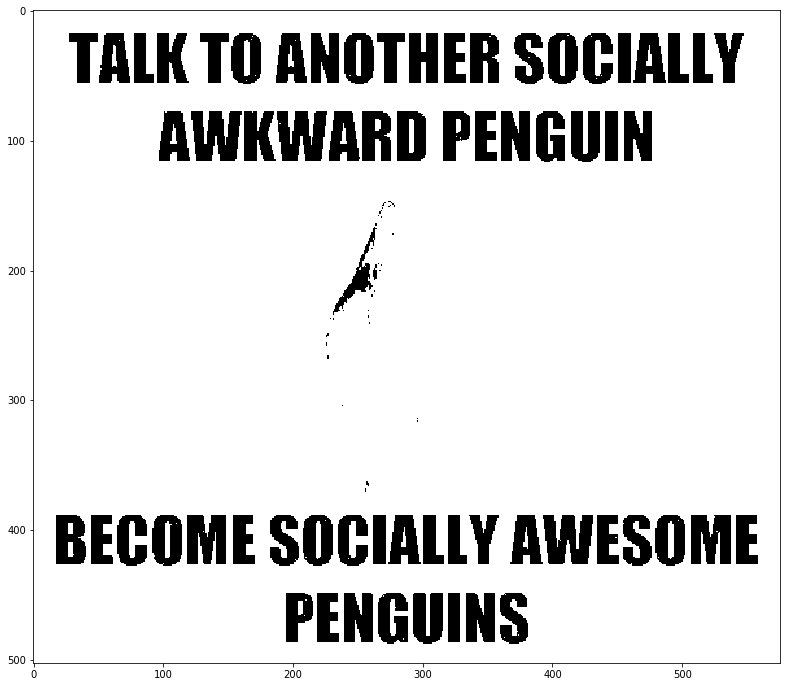

In [102]:
img = cv2.imread('images-text/sap1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

img_bin = img_gray > 240
img_inv = 255 - img_bin

plt.imshow(img_inv, 'gray')

custom_config = r'--oem 1 --psm 1'
pytesseract.image_to_string(img_inv, config=custom_config)

In [103]:
def ocr_pattern_image(image_name):
    img = cv2.imread('images-text/' + image_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    img_bin = img_gray > 240
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

    # img_bin = cv2.dilate(img_bin.astype('uint8'), kernel, iterations=1)
    img_bin = cv2.erode(img_bin.astype('uint8'), kernel, iterations=1)
    img_bin = cv2.dilate(img_bin.astype('uint8'), kernel, iterations=1)
    
    # img_bin = cv2.GaussianBlur(img_bin,(3,3),cv2.BORDER_DEFAULT)
    
    # Sharpening
    # kernel_sharpen = np.array([[-1,-1,-1], [-1,27,-1], [-1,-1,-1]])
    # img_bin = cv2.filter2D(img_bin, -1, kernel_sharpen)
    
    img_inv = 255 - img_bin
    
    plt.imshow(img_inv, 'gray')
    
    custom_config = r'--oem 1 --psm 1'
    return pytesseract.image_to_string(img_inv, config=custom_config)

TALK TO ANOTHER SOCIALLY
AWKWARD PENGUIN

7

-

BECOME SOCIALLY AWESOME
PENGUINS


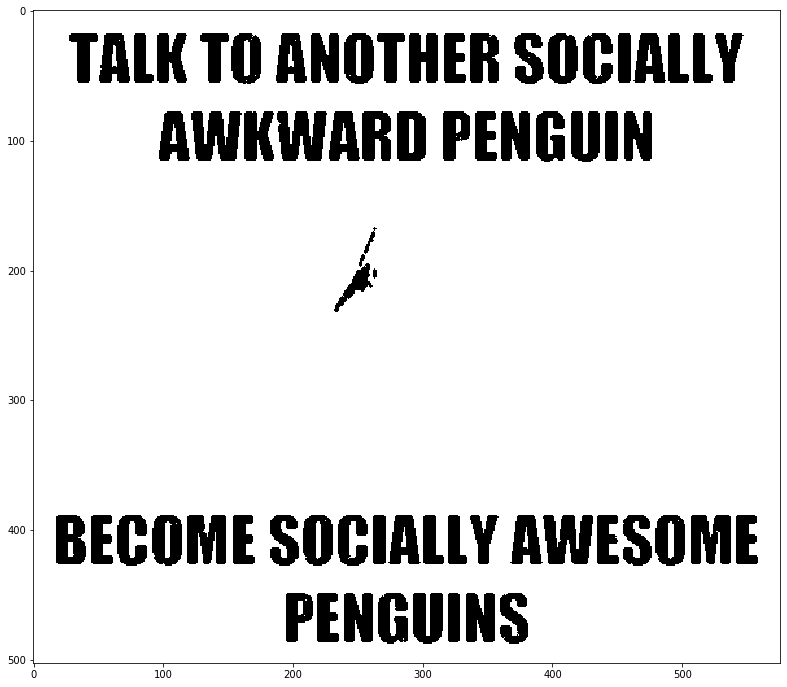

In [104]:
text = ocr_pattern_image('sap1.jpg')
print(text)

In [105]:
from os import listdir
listdir('images-text')

['img1.jpg',
 'pr.jpg',
 'pr2.jpg',
 'pr3.jpg',
 'sap1.jpg',
 'sap2.jpg',
 'sap3.jfif',
 'sap4.jpg',
 'text1.webp',
 'wi1.jfif',
 'wi2.jpg',
 'wi3.png']

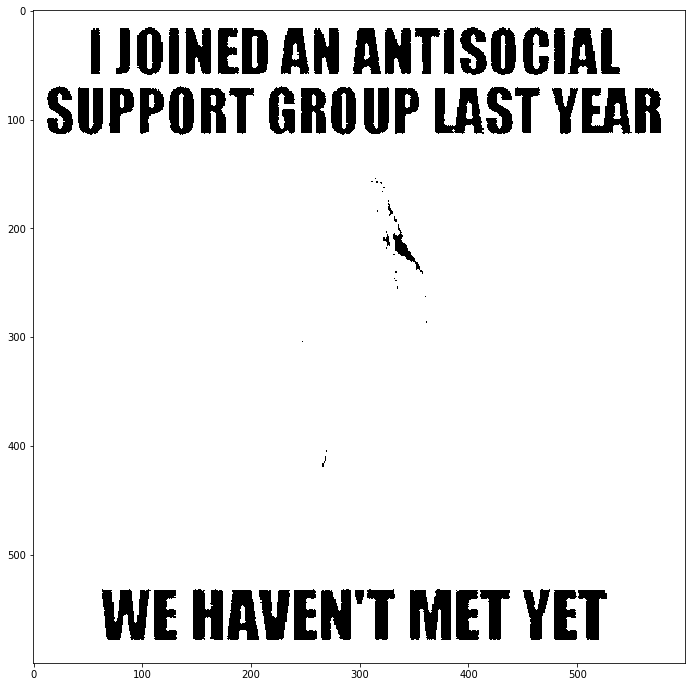

In [106]:
img = cv2.imread('images-text/sap4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

img_bin = img_gray > 245

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

img_dil = cv2.dilate(img_bin.astype('uint8'), kernel, iterations=1)
img_close = cv2.erode(img_dil.astype('uint8'), kernel, iterations=1)

img_inv = 255 - img_close

plt.imshow(img_inv, 'gray')

# Detection analysis

In [200]:
read_detections()

Image ../scraped_database/a0RA29q.jpg
Man
Human face

Image ../scraped_database/a0RA40X.jpg

Image ../scraped_database/a0RA6dX.jpg

Image ../scraped_database/a0RA78Z.jpg
Man
Clothing

Image ../scraped_database/a0RA7en.jpg

Image ../scraped_database/a0RAAxn.jpg
Person

Image ../scraped_database/a0RABqz.jpg
Cat

Image ../scraped_database/a0RADgO.jpg
Toy
Dog

Image ../scraped_database/a0RADvQ.jpg

Image ../scraped_database/a0RAe1d.jpg

Image ../scraped_database/a0RAEXB.jpg

Image ../scraped_database/a0RAmbQ.jpg

Image ../scraped_database/a0RAogz.jpg

Image ../scraped_database/a0RAq5X.jpg

Image ../scraped_database/a0RAqVq.jpg

Image ../scraped_database/a0RArOX.jpg

Image ../scraped_database/a0RAVrO.jpg

Image ../scraped_database/a0RAWpX.jpg
Woman
Man
Clothing
Human face

Image ../scraped_database/a0RAXyd.jpg
Poster
Woman
Human face

Image ../scraped_database/a0RAxYv.jpg
Woman

Image ../scraped_database/a0RAymB.jpg
Woman
Man
Human face

Image ../scraped_database/a0RAzmQ.jpg
Table

Image ..

Image ../scraped_database/a2RQZY1.jpg
Human hand

Image ../scraped_database/a2RQZzY.jpg

Image ../scraped_database/a3R90M5.jpg
Clothing

Image ../scraped_database/a3R9185.jpg

Image ../scraped_database/a3R94D7.jpg
Boat

Image ../scraped_database/a3R959N.jpg

Image ../scraped_database/a3R95O3.jpg
Man
Human face

Image ../scraped_database/a3R95R3.jpg

Image ../scraped_database/a3R95We.jpg
Woman
Human face

Image ../scraped_database/a3R96d1.jpg

Image ../scraped_database/a3R9901.jpg

Image ../scraped_database/a3R9ArQ.jpg

Image ../scraped_database/a3R9bAv.jpg
Man

Image ../scraped_database/a3R9ED1.jpg
Man
Human face

Image ../scraped_database/a3R9EKN.jpg
Person
Human face

Image ../scraped_database/a3R9Ewm.jpg
Dog

Image ../scraped_database/a3R9Gnr.jpg
Human face

Image ../scraped_database/a3R9n27.jpg
Person

Image ../scraped_database/a3R9N57.jpg
Man
Human face

Image ../scraped_database/a3R9oW3.jpg
Person
Human face

Image ../scraped_database/a3R9pB1.jpg
Man
Clothing
Human face

Image ..

Human face

Image ../scraped_database/a5RLPOV.jpg

Image ../scraped_database/a5RLPpg.jpg
Dog

Image ../scraped_database/a5RLPPN.jpg

Image ../scraped_database/a5RLPXy.jpg

Image ../scraped_database/a5RLPYr.jpg

Image ../scraped_database/a5RLpzG.jpg
Clothing
Human face

Image ../scraped_database/a5RLr1G.jpg

Image ../scraped_database/a5RLR5G.jpg

Image ../scraped_database/a5RLR6y.jpg
Man
Clothing

Image ../scraped_database/a5RLr8G.jpg

Image ../scraped_database/a5RLRAE.jpg
Person
Bee
Beetle
Insect
Spider

Image ../scraped_database/a5RLRBy.jpg

Image ../scraped_database/a5RLRdG.jpg
Human face

Image ../scraped_database/a5RLReo.jpg
Woman
Human face

Image ../scraped_database/a5RLRjo.jpg
Man
Human face

Image ../scraped_database/a5RLRKg.jpg
Man
Human face

Image ../scraped_database/a5RLRLV.jpg

Image ../scraped_database/a5RLrNO.jpg
Cat
Man
Human face

Image ../scraped_database/a5RLROO.jpg

Image ../scraped_database/a5RLRPg.jpg
Person

Image ../scraped_database/a5RLRqG.jpg
Pumpkin

Image ..

Human face

Image ../scraped_database/a85rGpQ.jpg

Image ../scraped_database/a85rGqO.jpg

Image ../scraped_database/a85rGQQ.jpg

Image ../scraped_database/a85rGvQ.jpg
Dog

Image ../scraped_database/a85rGX6.jpg

Image ../scraped_database/a85rGYp.jpg

Image ../scraped_database/a85rGyQ.jpg
Person
Clothing
Human face

Image ../scraped_database/a85rGzp.jpg

Image ../scraped_database/a85rj4d.jpg
Woman
Clothing
Human face

Image ../scraped_database/a85rjb6.jpg
Woman

Image ../scraped_database/a85rjBY.jpg
Man
Human face

Image ../scraped_database/a85rjMd.jpg

Image ../scraped_database/a85rjN3.jpg
Tree

Image ../scraped_database/a85rjxO.jpg

Image ../scraped_database/a85rL7Y.jpg

Image ../scraped_database/a85rM5d.jpg

Image ../scraped_database/a85rM8Q.jpg

Image ../scraped_database/a85rME3.jpg

Image ../scraped_database/a85rMmY.jpg
Man

Image ../scraped_database/a85rMYZ.jpg
Clothing
Human face

Image ../scraped_database/a85roBQ.jpg
Woman

Image ../scraped_database/a85roG6.jpg
Human face

Image 

Image ../scraped_database/aBgDgb2.jpg
Sunglasses
Man
Human face

Image ../scraped_database/aBgDgDN.jpg

Image ../scraped_database/aBgDgEx.jpg
Flag

Image ../scraped_database/aBgDgLD.jpg

Image ../scraped_database/aBgDgMO.jpg
Man
Human face

Image ../scraped_database/aBgDgN2.jpg
Cat

Image ../scraped_database/aBgDgp1.jpg
Woman
Man

Image ../scraped_database/aBgDgPx.jpg
Person

Image ../scraped_database/aBgDgpZ.jpg

Image ../scraped_database/aBgDgqZ.jpg

Image ../scraped_database/aBgDgRP.jpg
Man
Human face

Image ../scraped_database/aBgDgrQ.jpg
House

Image ../scraped_database/aBgDgw2.jpg
Human face

Image ../scraped_database/aBgDgxA.jpg

Image ../scraped_database/aBgDgY2.jpg

Image ../scraped_database/aBgDgyN.jpg
Man
Clothing
Human face

Image ../scraped_database/aBgDgzA.jpg

Image ../scraped_database/aBgDK4D.jpg

Image ../scraped_database/aBgDKE1.jpg
Monkey

Image ../scraped_database/aBgDKP1.jpg

Image ../scraped_database/aBgDKWP.jpg
Person
Man
Human face

Image ../scraped_database/aBg


Image ../scraped_database/aDgBgYO.jpg
Camera

Image ../scraped_database/aDgBgZG.jpg
Human face

Image ../scraped_database/aDgBj77.jpg
Tree

Image ../scraped_database/aDgBj7G.jpg

Image ../scraped_database/aDgBjbB.jpg

Image ../scraped_database/aDgBjMZ.jpg
Person
Human face

Image ../scraped_database/aDgBjOx.jpg
Girl
Dog

Image ../scraped_database/aDgBjP9.jpg
Person
Clothing
Human face

Image ../scraped_database/aDgBjPZ.jpg

Image ../scraped_database/aDgBjwZ.jpg

Image ../scraped_database/aDgBm6O.jpg
Human face

Image ../scraped_database/aDgBmDw.jpg
Human face

Image ../scraped_database/aDgBmGB.jpg
Man
Human face

Image ../scraped_database/aDgBmoB.jpg

Image ../scraped_database/aDgBmXG.jpg

Image ../scraped_database/aDgBmxZ.jpg

Image ../scraped_database/aDgBmYd.jpg
Poster

Image ../scraped_database/aDgBoB9.jpg

Image ../scraped_database/aDgBoBZ.jpg
Man
Clothing
Human face

Image ../scraped_database/aDgBoEZ.jpg

Image ../scraped_database/aDgBoKx.jpg

Image ../scraped_database/aDgBoLN.j

Image ../scraped_database/ag5RXpK.jpg
Person
Clothing

Image ../scraped_database/ag5RXwW.jpg

Image ../scraped_database/ag5RXyw.jpg
Person
Human face

Image ../scraped_database/ag5RXzq.jpg

Image ../scraped_database/ag5RY3g.jpg
Person

Image ../scraped_database/ag5Ryn1.jpg

Image ../scraped_database/ag5RyOx.jpg
Man
Clothing
Human face

Image ../scraped_database/aGg320G.jpg
Human face

Image ../scraped_database/aGg32bK.jpg
Man
Clothing
Human face

Image ../scraped_database/aGg32jw.jpg
Human face

Image ../scraped_database/aGg32LX.jpg

Image ../scraped_database/aGg32W7.jpg

Image ../scraped_database/aGg33Dw.jpg
Person
Human face

Image ../scraped_database/aGg34d7.jpg
Flag

Image ../scraped_database/aGg34Z7.jpg

Image ../scraped_database/aGg35N0.jpg
Person

Image ../scraped_database/aGg35wX.jpg

Image ../scraped_database/aGg363G.jpg
Bottle

Image ../scraped_database/aGg3760.jpg

Image ../scraped_database/aGg382G.jpg
Man
Human face
Car

Image ../scraped_database/aGg3A6z.jpg
Person
Poster



Coffee cup

Image ../scraped_database/am5D24o.jpg
Person

Image ../scraped_database/am5D279.jpg
Human face

Image ../scraped_database/am5D2bV.jpg

Image ../scraped_database/am5D2dv.jpg
Person
Poster
Human face

Image ../scraped_database/am5D2Ed.jpg
Person

Image ../scraped_database/am5D2G2.jpg
Human face

Image ../scraped_database/am5D2r4.jpg
Man
Clothing

Image ../scraped_database/am5D2zV.jpg
Human face

Image ../scraped_database/am5D542.jpg
Person
Clothing

Image ../scraped_database/am5D589.jpg
Man
Clothing

Image ../scraped_database/am5D599.jpg
Woman
Clothing
Human face

Image ../scraped_database/am5D5e2.jpg
Person

Image ../scraped_database/am5D5Ko.jpg

Image ../scraped_database/am5D5Oo.jpg
Hat
Human face

Image ../scraped_database/am5D5oy.jpg

Image ../scraped_database/am5D5Qd.jpg

Image ../scraped_database/am5D5Qj.jpg
Clothing
Human face

Image ../scraped_database/am5D5qV.jpg
Person

Image ../scraped_database/am5D5ro.jpg

Image ../scraped_database/am5D5V4.jpg

Image ../scraped_da

Image ../scraped_database/an5AY6b.jpg

Image ../scraped_database/an5AY7n.jpg
Dog

Image ../scraped_database/an5Ay95.jpg
Cat
Dog

Image ../scraped_database/an5AYDE.jpg

Image ../scraped_database/an5AYdo.jpg
Person

Image ../scraped_database/an5AYe5.jpg
Poster

Image ../scraped_database/an5Aygo.jpg

Image ../scraped_database/an5AYjz.jpg
Man
Human face

Image ../scraped_database/an5AyOB.jpg
Guitar

Image ../scraped_database/an5AYPL.jpg

Image ../scraped_database/an5AyVn.jpg
Human face

Image ../scraped_database/an5AyvV.jpg
Frog

Image ../scraped_database/an5AYWB.jpg
Person
Clothing
Human face

Image ../scraped_database/an5AyXn.jpg
Dress
Girl
Human face

Image ../scraped_database/an5Ayyq.jpg

Image ../scraped_database/an5p05b.jpg
Human face

Image ../scraped_database/an5p0eo.jpg
Man
Human face

Image ../scraped_database/an5p2AL.jpg

Image ../scraped_database/an5p3QL.jpg
Poster

Image ../scraped_database/an5p4Eb.jpg

Image ../scraped_database/an5p4r0.jpg
Toy

Image ../scraped_database/an5p6

Poster

Image ../scraped_database/aPRODKV.jpg
Human face

Image ../scraped_database/aPRODoR.jpg

Image ../scraped_database/aPRODYB.jpg

Image ../scraped_database/aPRODyG.jpg

Image ../scraped_database/aPROG8G.jpg

Image ../scraped_database/aPROG9V.jpg

Image ../scraped_database/aPROGDB.jpg
Woman
Man

Image ../scraped_database/aPROGzB.jpg
Man

Image ../scraped_database/aPROj0G.jpg

Image ../scraped_database/aPROjBG.jpg

Image ../scraped_database/aPROjbn.jpg
Man
Clothing
Human face

Image ../scraped_database/aPROjLg.jpg
Person

Image ../scraped_database/aPROjNB.jpg

Image ../scraped_database/aPROjpq.jpg
Human face

Image ../scraped_database/aPROjqn.jpg
Woman
Man
Clothing

Image ../scraped_database/aPROjwR.jpg

Image ../scraped_database/aPROM1P.jpg

Image ../scraped_database/aPROM3G.jpg
Bird

Image ../scraped_database/aPROMvP.jpg

Image ../scraped_database/aPROR1K.jpg

Image ../scraped_database/aPROR7R.jpg
Man
Human face

Image ../scraped_database/aPRORAq.jpg
Human face

Image ../scraped_

Image ../scraped_database/aV0G3rP.jpg

Image ../scraped_database/aV0G3yv.jpg
Man

Image ../scraped_database/aV0G3Z8.jpg

Image ../scraped_database/aV0GD9O.jpg

Image ../scraped_database/aV0GDe8.jpg
Human face

Image ../scraped_database/aV0GDKd.jpg

Image ../scraped_database/aV0GDp2.jpg
Croissant

Image ../scraped_database/aV0GDwy.jpg
Human face

Image ../scraped_database/aV0Ge28.jpg
Calculator
Mobile phone

Image ../scraped_database/aV0GeAv.jpg
Man
Clothing

Image ../scraped_database/aV0Gedw.jpg

Image ../scraped_database/aV0GeOO.jpg

Image ../scraped_database/aV0Gepv.jpg

Image ../scraped_database/aV0GeWw.jpg
Poster

Image ../scraped_database/aV0GeYP.jpg
Human face

Image ../scraped_database/aV0Gje8.jpg

Image ../scraped_database/aV0Gjzn.jpg

Image ../scraped_database/aV0GM2y.jpg
Person
Man
Human face

Image ../scraped_database/aV0GM6n.jpg
Human face

Image ../scraped_database/aV0GMBP.jpg
Person
Clothing
Human face

Image ../scraped_database/aV0GMDv.jpg

Image ../scraped_database/aV0G

Animal

Image ../scraped_database/ax7p142.jpg

Image ../scraped_database/ax7p1jM.jpg
Man
Human face
Glasses

Image ../scraped_database/ax7p1KL.jpg

Image ../scraped_database/ax7p1PK.jpg

Image ../scraped_database/ax7p1qD.jpg

Image ../scraped_database/ax7p1QM.jpg
Toy

Image ../scraped_database/ax7p2eM.jpg

Image ../scraped_database/ax7p2vp.jpg
Poster
Man
Human face

Image ../scraped_database/ax7p701.jpg
Man
Human face
Glasses

Image ../scraped_database/ax7p72W.jpg

Image ../scraped_database/ax7p7NW.jpg
Poster

Image ../scraped_database/ax7p7o2.jpg

Image ../scraped_database/ax7p7pM.jpg

Image ../scraped_database/ax7p7qK.jpg
Woman
Human face

Image ../scraped_database/ax7p7V1.jpg
Person
Woman
Human face

Image ../scraped_database/ax7p7x2.jpg
Woman

Image ../scraped_database/ax7p7yM.jpg

Image ../scraped_database/ax7p7zb.jpg
Woman
Human face

Image ../scraped_database/ax7p92L.jpg
Woman
Man
Human face

Image ../scraped_database/ax7p9dY.jpg

Image ../scraped_database/ax7p9EM.jpg
Clothing



Image ../scraped_database/az16qzz.jpg
Human face

Image ../scraped_database/az16r9x.jpg
Cattle

Image ../scraped_database/az16rAp.jpg
Boy
Clothing
Human face

Image ../scraped_database/az16rrj.jpg

Image ../scraped_database/az16rYm.jpg
Woman
Human face

Image ../scraped_database/az16V1p.jpg
Man
Human face

Image ../scraped_database/az16V2j.jpg
Man
Clothing
Human face

Image ../scraped_database/az16V7q.jpg

Image ../scraped_database/az16V9Z.jpg
Woman
Dog
Human face

Image ../scraped_database/az16VLK.jpg

Image ../scraped_database/az16VqZ.jpg
Footwear

Image ../scraped_database/az16Vvb.jpg
Woman
Clothing

Image ../scraped_database/az16Vxx.jpg

Image ../scraped_database/az16VYK.jpg
Man
Human face

Image ../scraped_database/az16X3q.jpg
Man
Footwear
Human face

Image ../scraped_database/az16X6b.jpg
Man
Clothing

Image ../scraped_database/az16XmK.jpg

Image ../scraped_database/az16XNb.jpg

Image ../scraped_database/az16Xnz.jpg

Image ../scraped_database/az16XoB.jpg

Image ../scraped_database

In [269]:
def number_detections(exact=False):
    with open('detection_tags_new.csv', 'r', newline='') as detections_file:
        lines = list(csv.reader(detections_file))
        
        objects_dict = copy.deepcopy(embeding_dict)
        total_objects = 0
        images_with_objects = 0
        images_without_objects = 0
        
        for x in range(1, len(lines)):
            
            feature_vector = lines[x][1]
            
            if int(feature_vector) != 0:
                images_with_objects += 1
            else:
                images_without_objects += 1
            
            for ind, val in enumerate(feature_vector):
                if int(val)!=0:
                    objects_dict[category_index[ind+1][NAME_KEY]] += int(val) if exact else 1
                    total_objects += int(val)
                    # print(category_index[ind+1][NAME_KEY], ":", v)
   
    return objects_dict, total_objects, images_with_objects, images_without_objects                    

In [270]:
objects_dict, total_objects, images_with_objects, images_without_objects = number_detections(exact=True)

sorted_objects_dict = {key: value for key, value in sorted(objects_dict.items(), key=lambda item: item[1], reverse=True)}

sorted_objects_dict

{'Human face': 2404,
 'Man': 1491,
 'Clothing': 808,
 'Person': 551,
 'Woman': 516,
 'Poster': 232,
 'Dog': 150,
 'Cat': 142,
 'Footwear': 109,
 'Car': 101,
 'Toy': 75,
 'Suit': 47,
 'Boy': 46,
 'Tree': 45,
 'Girl': 29,
 'Glasses': 29,
 'Bird': 26,
 'Monkey': 24,
 'Mobile phone': 23,
 'Computer monitor': 19,
 'Horse': 19,
 'House': 18,
 'Building': 17,
 'Window': 17,
 'Dress': 16,
 'Guitar': 15,
 'Airplane': 15,
 'Computer keyboard': 12,
 'Chair': 11,
 'Sculpture': 11,
 'Bicycle': 10,
 'Food': 10,
 'Bottle': 10,
 'Wheel': 10,
 'Flag': 9,
 'Picture frame': 9,
 'Animal': 9,
 'Laptop': 8,
 'Table': 8,
 'Book': 8,
 'Sunglasses': 7,
 'Billboard': 7,
 'Motorcycle': 7,
 'Penguin': 7,
 'Duck': 7,
 'Flower': 7,
 'Helmet': 7,
 'Whiteboard': 6,
 'Hat': 6,
 'Tiger': 6,
 'Apple': 5,
 'Cattle': 5,
 'Door': 5,
 'Rabbit': 5,
 'Television': 5,
 'Chicken': 5,
 'Toilet': 5,
 'Jeans': 5,
 'Van': 5,
 'Boat': 4,
 'Tower': 4,
 'Traffic sign': 4,
 'Land vehicle': 4,
 'Tie': 4,
 'Snack': 4,
 'Baked goods': 4,


In [272]:
print("Total objects :", total_objects)
print("Images with objects :", images_with_objects)
print("Images without objects :", images_without_objects)
print("Total images :", images_with_objects + images_without_objects)

Total objects : 7459
Images with objects : 3581
Images without objects : 2426
Total images : 6007


In [295]:
LIMIT = 15
objects_num = 0
last_category = ''

limit = LIMIT

for key, value in sorted_objects_dict.items():
    
    objects_num += int(value)
    
    limit -= 1
    if limit==0: 
        last_category=key 
        break
        
print("Objects percentage for first {0} objects\n{1} \ {2} = {3}%".format(LIMIT, objects_num, total_objects, objects_num/total_objects*100))
print("Last category :", last_category)

Objects percentage for first 15 objects
6746 \ 7459 = 90.44107789247889%
Last category : Girl


In [337]:
PERSON =             0b000000000000001
PEOPLE =             0b000000000000010
CAT =                0b000000000000100
DOG =                0b000000000001000
OTHER_ANIMAL =       0b000000000010000
POSTER =             0b000000000100000
CLOTHING =           0b000000001000000
CAR =                0b000000010000000
TOY =                0b000000100000000
TREE =               0b000001000000000
GLASSES =            0b000010000000000
BUILDING =           0b000100000000000
ELECTRONIC_DEVICE =  0b001000000000000
AIRPLANE =           0b010000000000000
GUITAR =             0b100000000000000

PERSON_NEGATE = 0b111111111111110


format(PEOPLE & PERSON, '#017b')

'0b000000000000000'

In [361]:
def mapping():
    
    with open('detection_tags_new.csv', 'r', newline='') as detections_file, open('mapped_detections.csv', 'w', newline='') as mapped_detections_file:
        
        lines = list(csv.reader(detections_file))
        writer = csv.writer(mapped_detections_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL) 
        
        objects_dict = copy.deepcopy(embeding_dict)
        
        for x in range(1, len(lines)):
            
            feature_vector = lines[x][1]
            
            image_path = lines[x][0]
            
            post_id = image_path[image_path.rfind('/') + 1 : image_path.rfind('.jpg')]

            
            person = False
            people = False
            human_faces = 0
            
            nfv = 0b000000000000000
            
            for ind, val in enumerate(feature_vector):
                
                if int(val)!=0:
                    category = category_index[ind+1][NAME_KEY]
                    
                    if (not people) and (category == "Person" or category == "Man" or category == "Woman" or category == "Boy" or category == "Girl"):
                            
                        if person:
                            nfv = nfv & PERSON_NEGATE
                            nfv = nfv | PEOPLE
                            people = True
                        elif int(val) > 1:
                            nfv = nfv & PERSON_NEGATE
                            nfv = nfv | PEOPLE
                            people = True
                        else:
                            nfv = nfv | PERSON
                        
                        person = True
                    
                    elif (not people) and category == "Human face":
                        
                        human_faces += int(val)
                        
                        if int(val) == 1 and not person:
                            nfv = nfv | PERSON
                        
                        if human_faces > 1:
                            nfv = nfv & PERSON_NEGATE
                            nfv = nfv | PEOPLE
                            people = True
                    
                    elif category == "Cat":
                        nfv = nfv | CAT
                        
                    elif category == "Dog":
                        nfv = nfv | DOG
                    
                    elif category == "Bird" or category == "Monkey" or category == "Horse" or category == "Animal" or category == "Penguin" or category == "Duck" or category == "Tiger" or category == "Cattle" or category == "Rabbit" or category == "Chicken":
                        nfv = nfv | OTHER_ANIMAL
                    
                    elif category == "Poster":
                        nfv = nfv | POSTER
                        
                    elif category == "Clothing" or category == "Suit" or category == "Dress" or category == "Jeans":
                        nfv = nfv | CLOTHING
                        
                    elif category == "Car":
                        nfv = nfv | CAR
                        
                    elif category == "Toy":
                        nfv = nfv | TOY
                        
                    elif category == "Tree":
                        nfv = nfv | TREE
                    
                    elif category == "Glasses" or category == "Sunglasses":
                        nfv = nfv | GLASSES
                    
                    elif category == "House" or category == "Building" or category == "Window":
                        nfv = nfv | BUILDING
                        
                    elif category == "Mobile phone" or category == "Computer monitor" or category == "Computer keyboard" or category == "Laptop" or category == 'Television':
                        nfv = nfv | ELECTRONIC_DEVICE
                    
                    elif category == "Airplane":
                        nfv = nfv | AIRPLANE
                    
                    elif category == "Guitar":
                        nfv = nfv | GUITAR
                    
                    # print(category_index[ind+1][NAME_KEY], ":", v)
            
            print(post_id, ":", format(nfv, '#017b'))
            writer.writerow([post_id, format(nfv, '#017b')])
            
            if nfv & PERSON & PEOPLE != 0:
                raise
                
    
    return None

In [362]:
mapping()

a0Nv0Pd : 0b000000000000000
a0Nv1bq : 0b000000000000010
a0Nv1jn : 0b000000000000010
a0Nv3ed : 0b000000000000000
a0Nv4Yv : 0b000000001000010
a0Nv7Vn : 0b000000000000000
a0Nv85Q : 0b000001000000000
a0Nv9nL : 0b000000000000000
a0NvB0n : 0b000000000000000
a0NvB3X : 0b000000000000000
a0NvB4v : 0b000000001000001
a0NvB5d : 0b000000000000100
a0NvB8L : 0b000000000000001
a0NvBEL : 0b000000000000000
a0NvBev : 0b000000000000010
a0NvBjB : 0b000000000000000
a0NvbKn : 0b000000000000000
a0NvbMX : 0b000000000000001
a0NvBoQ : 0b000000000100001
a0NvBOZ : 0b000000001000010
a0NvBqd : 0b000000000000010
a0NvBrz : 0b000000000000000
a0NvBVn : 0b000000000000000
a0NvBwZ : 0b000000000100000
a0NvBxO : 0b000000000000000
a0NvBXQ : 0b100000000000000
a0NvD5L : 0b000000000000000
a0NvdGL : 0b000000000000001
a0NvDLn : 0b000000000000010
a0NvDNO : 0b000000001000010
a0NvDpq : 0b000000000100001
a0NvDZB : 0b000000000000000
a0NveAq : 0b000000000000000
a0NvenO : 0b000000000000000
a0Nvezz : 0b000000000000000
a0Nvg8O : 0b00000000

a3wvBP8 : 0b000000000000001
a3wvbV7 : 0b000000000000000
a3wvbxr : 0b000000001000001
a3wvD58 : 0b000000000000010
a3wvDEv : 0b000000000000000
a3wvDLm : 0b000000000000001
a3wvDW1 : 0b000000001100010
a3wvdYe : 0b000000000000000
a3wvdz8 : 0b000000001000001
a3wve3v : 0b000000101000000
a3wve9N : 0b000000010000000
a3wvem1 : 0b000000000000000
a3wvEp8 : 0b010000000000000
a3wveVN : 0b000000000100000
a3wveZN : 0b000000000000000
a3wvGG7 : 0b000000000000010
a3wvgj1 : 0b000000000000000
a3wvGo7 : 0b000000000000000
a3wvKB8 : 0b000000000000001
a3wvm1m : 0b001000000000000
a3wvm3Q : 0b000000000000100
a3wvm9m : 0b000000000001001
a3wvMAv : 0b000000000000010
a3wvMbr : 0b000000000000001
a3wvmdQ : 0b000000000000001
a3wvmEN : 0b000000000100000
a3wvmer : 0b000000001000000
a3wvmK3 : 0b000000000000001
a3wvmL8 : 0b000000000010000
a3wvmmN : 0b000000000000001
a3wvmnQ : 0b000000000000000
a3wvmO1 : 0b000000000000000
a3wvmPv : 0b000000000000000
a3wvmR1 : 0b000000001000001
a3wvmX1 : 0b000000000000000
a3wvmYv : 0b00000000

a5WpYQE : 0b000000000000001
a5WpyRr : 0b000000000000000
a5WpyxN : 0b000000000000000
a6Kr05N : 0b000000000000000
a6Kr08L : 0b000000000000010
a6Kr0jR : 0b000000000000001
a6Kr0Nb : 0b000000000000000
a6Kr0oA : 0b000000000000001
a6Kr0P9 : 0b000000001000010
a6Kr0r2 : 0b000000000000001
a6Kr0ve : 0b000000000000001
a6Kr0We : 0b000000000000000
a6Kr0wR : 0b000000000000000
a6Kr0xL : 0b000000000000000
a6Kr0Yb : 0b000000000001000
a6Kr0Ze : 0b000000000000001
a6Kr20N : 0b000000000000000
a6Kr32N : 0b000000000000000
a6Kr34L : 0b000000000100000
a6Kr3Ab : 0b000000000000000
a6Kr3BN : 0b000000001000010
a6Kr3j2 : 0b000000000000000
a6Kr3NA : 0b000000000000000
a6Kr3nm : 0b000000000000010
a6Kr3o8 : 0b000000000000000
a6Kr3Pb : 0b000000000000000
a6Kr3RA : 0b000000000000000
a6Kr3yR : 0b000000000000000
a6Kr42e : 0b000000000000001
a6Kr48m : 0b000000000000000
a6Kr4A8 : 0b000000000000000
a6Kr4e2 : 0b000000000000010
a6Kr4Pq : 0b000000001000010
a6Kr4WA : 0b000000000100000
a6Kr5rR : 0b000000000000000
a6Kr66L : 0b00000000

a8GdxLO : 0b000000000000000
a8Gdxn1 : 0b000000000000000
a8GdxOp : 0b000000000000001
a8GdXoY : 0b000001000000000
a8GdxPQ : 0b000000000000000
a8GdxvV : 0b000000000000001
a8GdxWY : 0b000000000000000
a8GdxXV : 0b000000001000001
a8GdxyZ : 0b000000000000001
a8Gdxz1 : 0b000000000000010
a8GdxZQ : 0b000000000000000
a8Gdy2e : 0b000000000000000
a8Gdy41 : 0b000000001000000
a8GdY7e : 0b000000000000001
a8Gdyde : 0b000000000000001
a8GdZ2p : 0b000000001000010
a8GdZ43 : 0b000000000000000
a8GdZ71 : 0b000000101000001
a8GdZ8e : 0b000000000000001
a8Gdz9p : 0b000000000000010
a8GdZd6 : 0b000010000000010
a8GdZdp : 0b000000000100000
a8GdZEY : 0b000000010000000
a8GdZGY : 0b000000000100001
a8GdzjZ : 0b000000000000000
a8GdZL6 : 0b000000000000001
a8GdzmO : 0b000000001000000
a8GdZnd : 0b000000000000000
a8GdZNe : 0b000000000000010
a8GdZOO : 0b000000000000001
a8GdZp3 : 0b000000000000000
a8GdZQ3 : 0b000000000000000
a8GdZv3 : 0b000000000000000
a8GdZZY : 0b000000000100000
a9nj02K : 0b000000000000000
a9nj036 : 0b00000000

abG3N9r : 0b000000000000000
abG3nAv : 0b000000000000000
abG3nBp : 0b000000010000001
abG3NBv : 0b000000001000001
abG3NE9 : 0b000000000000000
abG3nG8 : 0b000000000000000
abG3NGX : 0b000000000000010
abG3njv : 0b000000000000001
abG3nMB : 0b000000000000000
abG3NML : 0b000000100000000
abG3nn8 : 0b000000000000010
abG3NnX : 0b000010000000001
abG3nOE : 0b000000000100000
abG3NpO : 0b000000000000010
abG3npr : 0b000000000000000
abG3NQE : 0b000000001100010
abG3nr8 : 0b000000001000001
abG3NR9 : 0b000000000000000
abG3NVr : 0b000000000000001
abG3NWb : 0b000000000000001
abG3nXp : 0b000000000000001
abG3nzr : 0b000000000000000
abG3nZX : 0b000000100000000
abG3o2p : 0b000000000000000
abG3OBO : 0b000000000000001
abG3oev : 0b000000000000010
abG3omL : 0b000000000000010
abG3ooX : 0b000000000000000
abG3oW9 : 0b000000000000000
abG3oXp : 0b000000000000001
abG3Qjr : 0b000000000000001
abG3Rxr : 0b000000000000000
abG3rZX : 0b000000000000000
abG3veE : 0b000000000000010
abG3W0E : 0b000000000000001
abG3w4r : 0b00000000

aD4RvoG : 0b000000000000001
aD4RvOO : 0b000000000000101
aD4RVQd : 0b000000000000000
aD4RvwK : 0b000010001100001
aD4RvxB : 0b000000000001000
aD4RWD7 : 0b000000000001000
aD4RWDN : 0b000000000000000
aD4RWrO : 0b000000000000001
aD4RxoB : 0b000000000000000
aD4RxQN : 0b000000000000010
aD4Ry07 : 0b000000000000000
aD4Ry0N : 0b000000000000000
aD4Ry2d : 0b000000000000000
aD4RY47 : 0b000000000000000
aD4RY4N : 0b000000000000000
aD4Ry59 : 0b000000000001000
aD4Ry5Z : 0b000000000000000
aD4Ry9Z : 0b000000000000000
aD4RyBd : 0b000000000000001
aD4RyBO : 0b001000000000000
aD4RyDw : 0b000000000000000
aD4Rye9 : 0b000000000000000
aD4RyEw : 0b000000000000100
aD4Ryg9 : 0b000000000000000
aD4RYGO : 0b000000000000001
aD4RyLx : 0b000000000000001
aD4RyLZ : 0b000000000000000
aD4RyMB : 0b000000001000010
aD4RynK : 0b001000000000000
aD4RyPB : 0b000000000000001
aD4RyRG : 0b000000000110000
aD4RyWx : 0b000000000000000
aD4RyWZ : 0b000000000000001
aD4RyX7 : 0b000000000000000
aD4Ryx9 : 0b000000000000010
aD4Ryyw : 0b00000000

aEPdbPK : 0b000000000000001
aEPdbqG : 0b000000000000000
aEPdbvn : 0b000000000000000
aEPdbzN : 0b000000000100000
aEPdBZO : 0b000000000000000
aEPdD5K : 0b000000000000000
aEPddDM : 0b000000001000001
aEPddLp : 0b000000001100000
aEPdDqO : 0b000000000000001
aEPddyx : 0b000000001000000
aEPdE3p : 0b000000000000000
aEPdEBK : 0b000000001000001
aEPdEdN : 0b000000000000001
aEPdEVn : 0b000000000000000
aEPdEWM : 0b000000000000000
aEPdg4o : 0b000000000000001
aEPdgdn : 0b000000000000000
aEPdgmK : 0b000000001000001
aEPdGxO : 0b000000000000001
aEPdj9p : 0b000000000000001
aEPdje9 : 0b000000000000000
aEPdjgp : 0b000000000000000
aEPdjoM : 0b000000000000000
aEPdjpO : 0b000000010000000
aEPdjRK : 0b000000000000000
aEPdjWN : 0b000000001000010
aEPdKge : 0b000000000000000
aEPdKjn : 0b000000000000000
aEPdKyn : 0b000000000000001
aEPdm0p : 0b000000001000010
aEPdm2o : 0b000000000000001
aEPdm7e : 0b000000000000000
aEPdmBx : 0b000000000000100
aEPdmDn : 0b000000000000010
aEPdmEN : 0b000000000110000
aEPdmep : 0b00000000

aj9Qdop : 0b000000000000001
aj9QdR8 : 0b000000001000001
aj9Qe21 : 0b000000001000000
aj9Qe71 : 0b000000001000010
aj9Qe8R : 0b000000000000000
aj9QeBQ : 0b000000000000010
aj9QeD0 : 0b000000000000001
aj9Qegq : 0b000000000001000
aj9Qenw : 0b000000001000001
aj9QEO0 : 0b000000000000000
aj9QeOG : 0b000000001000010
aj9Qeq0 : 0b000000000000001
aj9Qerx : 0b000000000000010
aj9QeWx : 0b000000000001000
aj9QEXG : 0b000000000000000
aj9QG7w : 0b000000000000000
aj9QGeQ : 0b000000000000000
aj9QGox : 0b000000001000010
aj9Qj6x : 0b000001000000000
aj9Qj71 : 0b000000000000100
aj9Qj8R : 0b000000001000001
aj9Qjvg : 0b000010000000001
aj9QLGx : 0b000000000000000
aj9QM7R : 0b000000000001000
aj9Qme8 : 0b000000000000000
aj9QMew : 0b000000000000001
aj9QMg0 : 0b000000000000000
aj9Qmzx : 0b000000000010000
aj9Qnr8 : 0b000000000000001
aj9QOQx : 0b000000000000000
aj9Qp0q : 0b000000000000001
aj9Qp3G : 0b000000100000001
aj9QP40 : 0b000000001000010
aj9Qp48 : 0b000000000000001
aj9Qp6q : 0b000000001000001
aj9Qp88 : 0b00000000

amvqKr9 : 0b000000001000010
amvqKRV : 0b000000000000001
amvqKW6 : 0b000000000000001
amvqKwd : 0b000000000000001
amvqKz9 : 0b000000000001000
amvqL29 : 0b000000001000010
amvqM39 : 0b000000000000000
amvqmB2 : 0b000000000000000
amvqmMV : 0b000000000100000
amvqn1d : 0b000000000100000
amvqn1j : 0b000000000100000
amvqn7V : 0b000000001000001
amvqn9X : 0b001000000000001
amvqnEo : 0b000000010000000
amvqNK2 : 0b000000000000000
amvqnN6 : 0b000000000000000
amvqnV6 : 0b000000000000001
amvqnyv : 0b000000000000000
amvqNz6 : 0b000000000000001
amvqO9X : 0b000000000000000
amvqOEo : 0b000000000000000
amvqOLy : 0b000000000000001
amvqOOV : 0b000000000000000
amvqopd : 0b000000000000001
amvqORy : 0b000010000000001
amvqOx2 : 0b000000000000000
amvqOzv : 0b000000000000000
amvqPj6 : 0b000000000000000
amvqpp9 : 0b000000000000010
amvqpw2 : 0b000000000100000
amvqPyo : 0b000000000000000
amvqq0y : 0b000000000000000
amvqQ1v : 0b000000000000000
amvqQ5y : 0b000000000000000
amvqQbd : 0b000000000000010
amvqqbX : 0b00000000

aNgmGOw : 0b000000000000000
aNgmGPr : 0b000000000000000
aNgmGVb : 0b000000000000010
aNgmgy6 : 0b000000000000010
aNgmGZ3 : 0b000000000000000
aNgmj64 : 0b000000000000000
aNgmjXG : 0b000000000000001
aNgmKj4 : 0b000000000000000
aNgmLmA : 0b000000001000001
aNgmM7w : 0b000000000000010
aNgmmBb : 0b000000001000000
aNgmmLr : 0b000000000000010
aNgmmpG : 0b000000000000001
aNgmMy6 : 0b000000000000000
aNgmMzb : 0b000000000000000
aNgmn1b : 0b000000000000001
aNgmN2G : 0b000000000000001
aNgmN3v : 0b000000000000000
aNgmn4v : 0b000000000000000
aNgmN7b : 0b000000010000000
aNgmNDK : 0b000000000000010
aNgmNdr : 0b000000000100000
aNgmNgb : 0b000000000000000
aNgmNGr : 0b000000000000000
aNgmNjv : 0b000000000000000
aNgmNKG : 0b000000000000000
aNgmNNb : 0b000000000000000
aNgmNnG : 0b000000000000000
aNgmNOA : 0b000000000000001
aNgmNov : 0b000000000000000
aNgmNQ3 : 0b000000000000010
aNgmNqG : 0b000000001000010
aNgmNV6 : 0b000000001000010
aNgmNZv : 0b000000000000000
aNgmoDb : 0b000000000000000
aNgmOrv : 0b00000000

aP76QvQ : 0b000000000000001
aP76qzn : 0b000000000000000
aP76r2P : 0b000000000000010
aP76rqV : 0b000000000000001
aP76RXw : 0b000000000000010
aP76RyR : 0b001000000000001
aP76V3P : 0b000000000000000
aP76VAV : 0b000000000000010
aP76vdV : 0b000000000000000
aP76VGG : 0b000000000000100
aP76vOG : 0b000000000000000
aP76VRB : 0b000000000010000
aP76VXq : 0b000000000000001
aP76xdP : 0b000000000000001
aP76xjw : 0b000000000000000
aP76yBB : 0b000000000100000
aP76Ydg : 0b000000000000000
aP76YKV : 0b000000000000010
aP76YVn : 0b000000000000000
aP76zBP : 0b000000000000001
aP76zeG : 0b000000000000000
aP76zjV : 0b000000000000001
aP76zKR : 0b000000000001000
aP76zLP : 0b000000000100000
aP76zNR : 0b000000000000001
aP76zPq : 0b000000001100001
aP76zrn : 0b000000000000000
aP76zwg : 0b000000000000000
aP76zxQ : 0b000000000000000
aP76zyn : 0b000000000000000
aP76zzB : 0b000000000000001
aP76zZR : 0b000000000000000
apGK3BW : 0b000000000000000
apGK40E : 0b000000001000001
apGK41W : 0b000000000000100
apGK43W : 0b00000000

aR76GeQ : 0b000000000000000
aR76GM5 : 0b000000001000010
aR76Gqq : 0b000000000000000
aR76GYA : 0b000000000000001
aR76jg5 : 0b000000000000001
aR76jX7 : 0b000000000000000
aR76MRj : 0b000000000000100
aR76N0Q : 0b000000000000000
aR76n1M : 0b000000000000000
aR76n2A : 0b000000000000000
aR76n3j : 0b000000000000000
aR76n47 : 0b000000000000000
aR76N52 : 0b000000000000000
aR76n7G : 0b000000000000000
aR76n95 : 0b000000000000000
aR76nAy : 0b000000000000010
aR76ndj : 0b000000001000001
aR76ne5 : 0b000000000000000
aR76nEQ : 0b000000000000000
aR76ngB : 0b000000000000001
aR76njj : 0b000000000000000
aR76nK5 : 0b001000000000000
aR76nL7 : 0b000000000000000
aR76nM2 : 0b000000000000010
aR76Nn7 : 0b000000000000001
aR76nOA : 0b000000100000000
aR76nPB : 0b000000001000001
aR76npM : 0b000000001000010
aR76nqM : 0b000000000000001
aR76Nr7 : 0b000000000000000
aR76nRB : 0b000000000000000
aR76NvB : 0b000000000000001
aR76nvq : 0b001000000000000
aR76nVy : 0b000000000000000
aR76nwA : 0b000000000001000
aR76nZ2 : 0b00000000

avz2EOb : 0b000000000000001
avz2EzE : 0b000000000000000
avz2g5n : 0b000000000000010
avz2GZO : 0b000000001000001
avz2j8n : 0b000000001000010
avz2jbb : 0b000000000000000
avz2jEO : 0b000000000000010
avz2jL5 : 0b000000000000001
avz2jLZ : 0b000000000000000
avz2jnd : 0b000000010000000
avz2jzn : 0b000000000000010
avz2K9O : 0b000000000000000
avz2KeW : 0b000000000000000
avz2KEX : 0b000100000000000
avz2KK5 : 0b000000000000000
avz2KLE : 0b000000000000001
avz2KNd : 0b000000000000001
avz2KOZ : 0b000000000000000
avz2KPE : 0b000000000000100
avz2KVZ : 0b000000000000001
avz2Kxb : 0b000000000000000
avz2KXE : 0b000000000000000
avz2KxX : 0b000000000000001
avz2KZO : 0b000000000000000
avz2LgO : 0b000000000000000
avz2M0W : 0b000000000000001
avz2M1d : 0b000000000000000
avz2M3Z : 0b000000001100001
avz2M7O : 0b000000000000001
avz2M8q : 0b000000000000100
avz2M9X : 0b000000000000010
avz2mAW : 0b000000000000000
avz2MAZ : 0b000000000000000
avz2Mb5 : 0b000000000000000
avz2MBO : 0b000000000000001
avz2Med : 0b00000000

ax7ppgW : 0b000000000000000
ax7ppKn : 0b000000000000100
ax9E09M : 0b000000000000000
ax9E0OW : 0b000000000000010
ax9E4eL : 0b000000001000010
ax9E4GY : 0b000000000000000
ax9E4KD : 0b000000001000010
ax9E4Mn : 0b000000000000000
ax9E4Xp : 0b000000000000001
ax9E52W : 0b000000000000000
ax9E55K : 0b000000001000001
ax9E56Y : 0b000000000000000
ax9E59K : 0b000000001000001
ax9E5An : 0b000000000000000
ax9E5ep : 0b000001000000000
ax9E5K1 : 0b000000000000000
ax9E5o2 : 0b000000000000000
ax9E5OL : 0b000000000000000
ax9E5PD : 0b000000000000000
ax9E5qb : 0b000000000000001
ax9E5rb : 0b000000000000000
ax9E5WM : 0b000000000000010
ax9E5y2 : 0b000000000000010
ax9E5zb : 0b000000000100000
ax9E5ZW : 0b000000000000000
ax9E6Y1 : 0b000000000000000
ax9E7Rb : 0b000000001000001
ax9E80Y : 0b000000100000000
ax9E85D : 0b000000000000010
ax9E8eM : 0b000000000000000
ax9EAD2 : 0b000000000000000
ax9EAGK : 0b000000001000001
ax9EAKM : 0b000000000000000
ax9EAoD : 0b000000000000000
ax9EAvn : 0b000000000000010
ax9EAwY : 0b00000000

az160oj : 0b000000000000000
az16nMz : 0b000000001000001
aZ799X3 : 0b000000000000001
aZ799xV : 0b000000000000000
azm729K : 0b000000000000000
azm72Mz : 0b000000000000000
azm736p : 0b000000000000000
azm73mb : 0b000000001000000
azm73xZ : 0b000000000000000
azm743m : 0b000000000100000
azm745x : 0b000000000000000
azm74EK : 0b000000000000000
azm74vb : 0b000000000000000
azm74WZ : 0b000000000000010
azm74ym : 0b000000000000000
azm77BN : 0b000000000000000
azm77Gp : 0b000000000000000
azm78mK : 0b000000010000000
azm78Nz : 0b000000001000010
azm79Dq : 0b000000000000001
azm7B0K : 0b000000000000001
azm7B1q : 0b000000000000000
azm7b3j : 0b000000000000000
azm7B5z : 0b000000000100000
azm7B6z : 0b000000000000001
azm7beB : 0b000000001000010
azm7BKm : 0b000000000000000
azm7D3j : 0b000000000000000
azm7D4m : 0b000000001000001
azm7dBq : 0b000000000000001
azm7DBZ : 0b000000000000000
azm7DmB : 0b000000000000001
azm7Dmx : 0b000000000000000
azm7Dop : 0b000000000000000
azm7Dpx : 0b000000000000001
azm7DQm : 0b00000000